In [ ]:
#Business Problem
#Note: Some customers are having missing values for credit consumption. You need to build the model using customer’s data where credit consumption is non- missing’s. You need to predict the credit consumption for next three months for the customers having missing values.

In [16]:
pip install pandas_profiling

Defaulting to user installation because normal site-packages is not writeable
  Using cached joblib-1.1.1-py2.py3-none-any.whl.metadata (5.2 kB)
Using cached joblib-1.1.1-py2.py3-none-any.whl (309 kB)
  Attempting uninstall: joblib
    Found existing installation: joblib 1.5.1
    Uninstalling joblib-1.5.1:
      Successfully uninstalled joblib-1.5.1
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-learn 1.5.1 requires joblib>=1.2.0, but you have joblib 1.1.1 which is incompatible.


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

#!pip install pandas_profiling 
#import pandas_profiling 
import scipy.stats as stats
import statsmodels as sm
%matplotlib inline

#import pandas_profiling

import sklearn as sk
from sklearn import metrics

plt.rcParams['figure.figsize'] = 6, 4
plt.rcParams['axes.grid'] = True

#These will help you to see all records as well as columns in the data set
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [19]:
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor

In [21]:
# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [22]:
# Create Data audit Report for categorical variables
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [23]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode().iloc[0])
    return x

In [24]:
# An utility function to create dummy variable
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df

In [25]:
credit_consum=pd.read_excel(r"C:\Users\DELL\OneDrive\Desktop\assignment\11. Capstone Case Study - Predict Cred Card Consumption\CreditConsumptionData.xlsx",engine = 'openpyxl')  # Credit consumption data
credit_demo=pd.read_excel(r"C:\Users\DELL\OneDrive\Desktop\assignment\11. Capstone Case Study - Predict Cred Card Consumption\CustomerDemographics.xlsx",engine = 'openpyxl')   # Customers demographics data
credit_behav=pd.read_excel(r"C:\Users\DELL\OneDrive\Desktop\assignment\11. Capstone Case Study - Predict Cred Card Consumption\CustomerBehaviorData.xlsx", engine = 'openpyxl')  # Customers Behavior data

In [27]:
df = pd.merge(credit_consum,credit_demo, on = 'ID', how ='inner' )
final_data= pd.merge(df,credit_behav, on = 'ID', how ='inner' )
final_data

,ID,cc_cons,account_type,gender,age,Income,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,personal_loan_active,vehicle_loan_active,personal_loan_closed,vehicle_loan_closed,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,loan_enq,emi_active
0,17051,16239.0,current,M,30,MEDIUM,26.4,9,9,355,0,2017.460,29066.66,15919.84,2197.00,3752.000,29798.00,1.0,4,35,6,2,13,345000,1,1,1.0,1,115818.74,158000.00,550.0,4795.0,33855.84,33401.00,70.0,36,135149.22,14282.00,39805.00,47,20,41860.0,32734.75,80959.00,36,9,171200.0,Y,3448.84
1,11491,39002.0,current,M,37,LOW,14.4,7,7,485,0,7687.000,1308.00,41888.92,2216.92,7060.530,3143.36,2.0,27,50,1,4,14,369000,1,1,1.0,1,137553.95,187788.10,4699.0,-5439.0,32960.00,32339.00,11.0,4,44368.00,21935.71,67100.00,0,8,113367.0,60974.75,495080.00,5,3,15694.0,Y,3812.69
2,7433,21182.0,current,M,33,MEDIUM,3.2,1,1,764,0,9094.460,14825.95,3087.64,769.59,25602.595,1445.00,44.0,8,47,1,1,30,27000,1,1,1.0,1,55700.00,165970.90,25508.0,6885.0,115190.10,42200.00,62.0,3,19360.00,56317.68,377994.06,2,14,168000.0,425802.96,115707.38,7,58,28058.0,Y,9432.90
3,14606,8123.0,current,M,63,LOW,10.2,6,6,863,0,3126.000,4616.33,8676.80,5923.00,6717.000,18747.00,4.0,30,1,2,6,70,195000,1,1,1.0,1,10000.00,51000.00,50000.0,20324.0,34921.12,41233.00,90.0,1,58236.00,250858.09,416.57,45,44,57750.0,25537.91,63606.00,12,0,24459.0,Y,144.61
4,8381,28282.0,saving,M,33,MEDIUM,26.4,6,6,523,0,24988.720,10091.23,10132.00,3477.00,4667.000,511.00,2.0,8,5,18,5,22,47000,1,1,1.0,1,11878.60,187788.10,908.0,0.0,41330.04,76582.00,55.0,30,38912.00,176267.55,30820.00,1,2,18405.0,64687.32,62353.35,49,35,31574.0,Y,1887.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,12512,NaN,current,M,35,MEDIUM,13.5,1,1,523,0,4641.500,5979.58,6008.61,4410.00,41743.000,1884.00,26.0,1,4,1,2,26,595000,1,1,1.0,1,84446.00,961916.90,492.0,553.0,41314.91,37646.41,6.0,14,27825.00,34952.75,45461.00,35,11,32944.0,105488.53,125470.83,21,50,58037.0,Y,7870.88
19996,14224,NaN,current,M,53,MEDIUM,9.9,7,7,723,1,4994.450,2805.37,23214.00,5870.00,1041.000,1008.73,37.0,56,50,18,1,58,13000,1,1,1.0,1,1892440.00,295150.90,10271.0,20324.0,216.25,1605.00,32.0,26,27912.00,17261.41,85422.00,5,8,8850.0,77112.66,86559.00,62,38,24110.0,Y,3668.30
19997,18740,NaN,current,M,62,HIGH,37.8,8,8,863,1,3262.145,2871.00,7335.25,11774.04,4130.000,1413.00,12.0,77,1,1,2,17,124000,1,1,1.0,1,115.45,200015.58,30000.0,6885.0,89327.00,80044.00,32.0,14,14580.00,142002.00,68985.86,10,108,35819.0,57192.48,80627.00,2,18,1769.0,Y,5450.34
19998,18134,NaN,current,M,34,MEDIUM,12.6,4,4,882,0,12824.010,4866.00,12242.48,284.00,15132.770,37911.00,67.0,1,4,1,44,67,371000,1,1,1.0,1,48796.45,1631.11,925.0,10455.0,191780.00,66057.00,40.0,5,23881.00,156995.05,13558.00,11,12,39083.0,82039.00,24332.00,117,64,37255.0,Y,59.29


In [28]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 49 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            20000 non-null  int64  
 1   cc_cons                       15000 non-null  float64
 2   account_type                  20000 non-null  object 
 3   gender                        20000 non-null  object 
 4   age                           20000 non-null  int64  
 5   Income                        20000 non-null  object 
 6   Emp_Tenure_Years              20000 non-null  float64
 7   Tenure_with_Bank              20000 non-null  int64  
 8   region_code                   20000 non-null  int64  
 9   NetBanking_Flag               20000 non-null  int64  
 10  Avg_days_between_transaction  20000 non-null  int64  
 11  cc_cons_apr                   20000 non-null  float64
 12  dc_cons_apr                   20000 non-null  float64
 13  c

In [29]:
 ## Non missing data according to CC_cons, as we will predict CC_Cons on missing data so seperate the nonmissing and missing 
    # on the basis of cc_cons

In [30]:
#credit_spend = final_data[-final_data.cc_cons.isna()] 
credit_spend_existing = final_data[final_data.cc_cons.isnull()==0]
credit_spend_new = final_data[final_data.cc_cons.isnull()==1]

In [31]:
# Now we have two datasets namely credit_spend_existing on which model will be build and credit_spend_new on which 
# we will find cc_cons for our new datasets

In [32]:
#Data exploratory analysis and Data understanding

In [33]:
import pandas as pd
print(pd.__version__)

2.2.2


In [34]:
credit_spend_existing.info()   # data understanding using .info(), .shape , univariate , bivariate analysis

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 0 to 14999
Data columns (total 49 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            15000 non-null  int64  
 1   cc_cons                       15000 non-null  float64
 2   account_type                  15000 non-null  object 
 3   gender                        15000 non-null  object 
 4   age                           15000 non-null  int64  
 5   Income                        15000 non-null  object 
 6   Emp_Tenure_Years              15000 non-null  float64
 7   Tenure_with_Bank              15000 non-null  int64  
 8   region_code                   15000 non-null  int64  
 9   NetBanking_Flag               15000 non-null  int64  
 10  Avg_days_between_transaction  15000 non-null  int64  
 11  cc_cons_apr                   15000 non-null  float64
 12  dc_cons_apr                   15000 non-null  float64
 13  cc_con

In [35]:
# '''As we have to predict credit consumption means credit spend by the customer that is our target variable, 
#that will be a numeric value so that this is a regression problem. 

In [36]:
credit_spend_existing.shape    # no. of rows and columns

(15000, 49)

In [37]:
print(list(credit_spend_existing.columns))

['ID', 'cc_cons', 'account_type', 'gender', 'age', 'Income', 'Emp_Tenure_Years', 'Tenure_with_Bank', 'region_code', 'NetBanking_Flag', 'Avg_days_between_transaction', 'cc_cons_apr', 'dc_cons_apr', 'cc_cons_may', 'dc_cons_may', 'cc_cons_jun', 'dc_cons_jun', 'cc_count_apr', 'cc_count_may', 'cc_count_jun', 'dc_count_apr', 'dc_count_may', 'dc_count_jun', 'card_lim', 'personal_loan_active', 'vehicle_loan_active', 'personal_loan_closed', 'vehicle_loan_closed', 'investment_1', 'investment_2', 'investment_3', 'investment_4', 'debit_amount_apr', 'credit_amount_apr', 'debit_count_apr', 'credit_count_apr', 'max_credit_amount_apr', 'debit_amount_may', 'credit_amount_may', 'credit_count_may', 'debit_count_may', 'max_credit_amount_may', 'debit_amount_jun', 'credit_amount_jun', 'credit_count_jun', 'debit_count_jun', 'max_credit_amount_jun', 'loan_enq', 'emi_active']


In [38]:
##Univariate major purpose is to describe; It takes data, summarizes that data and finds patterns in the data and to see distribution of variables

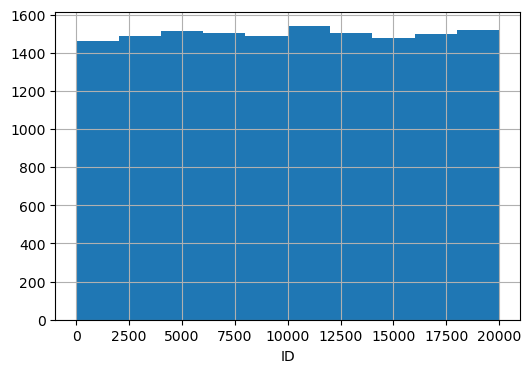

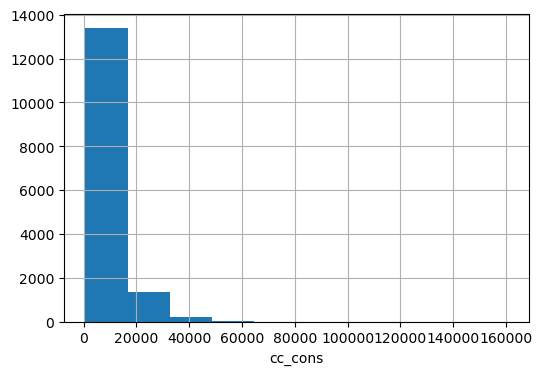

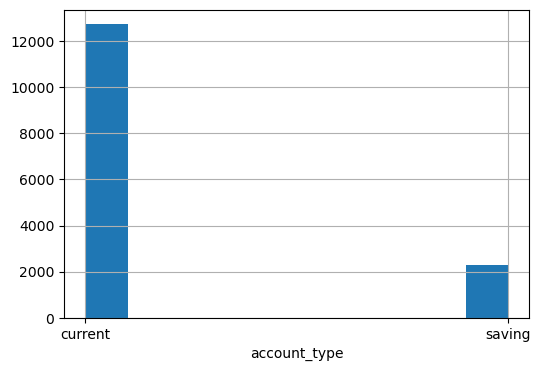

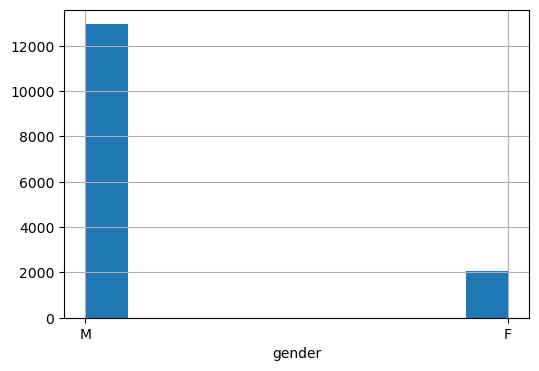

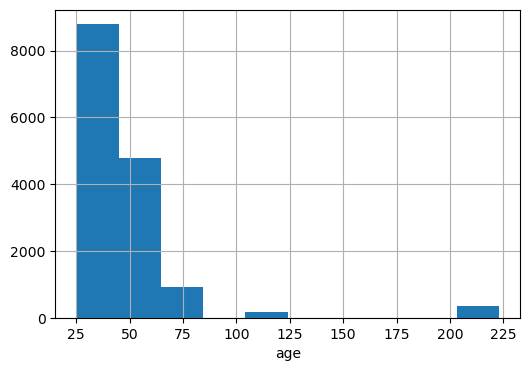

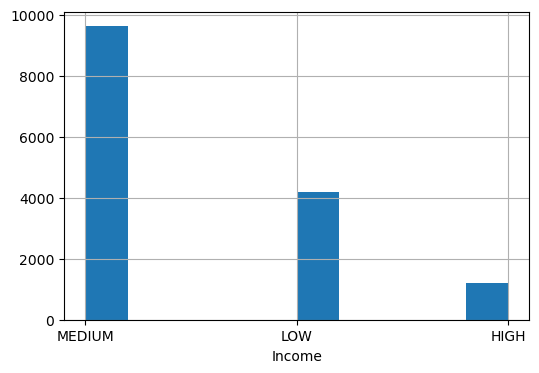

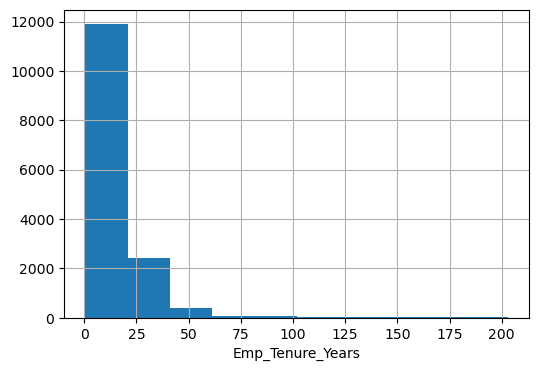

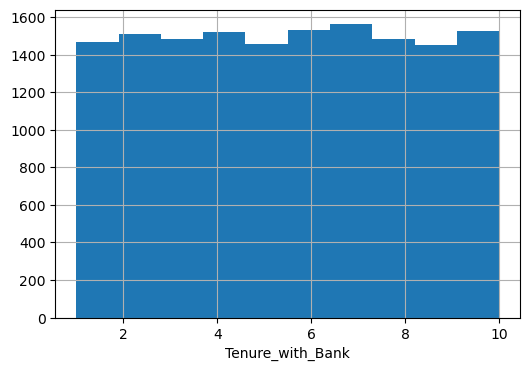

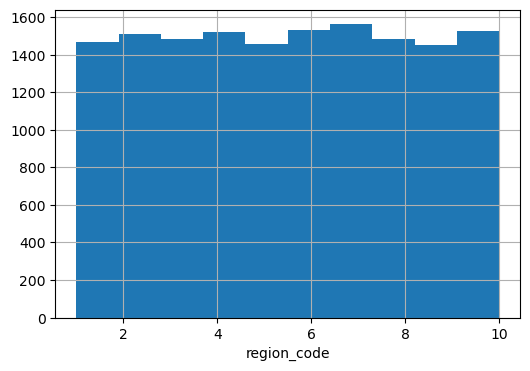

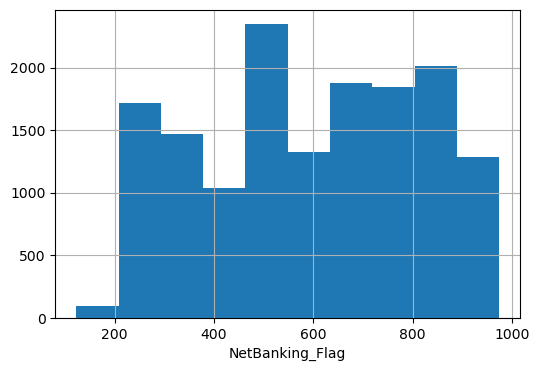

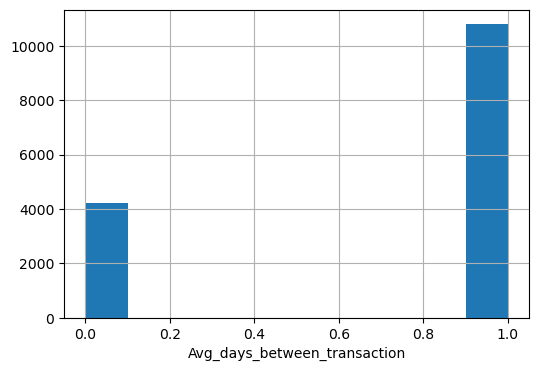

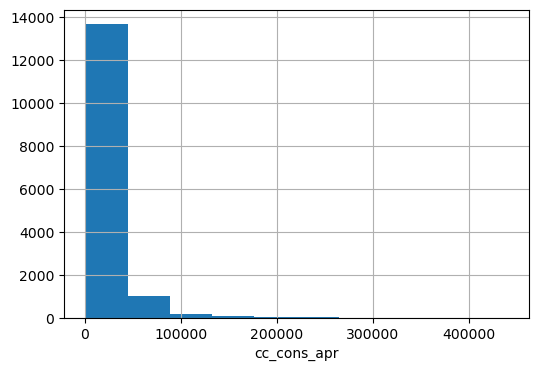

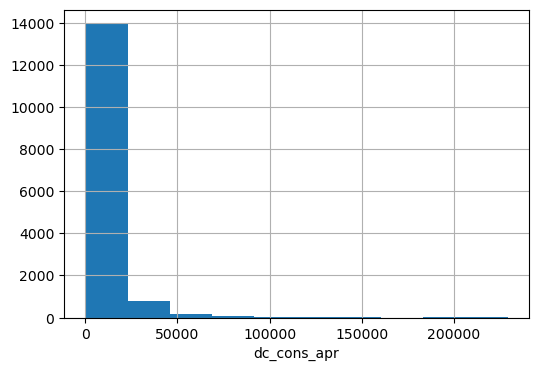

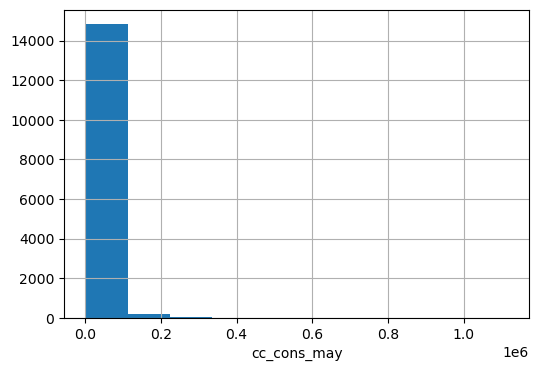

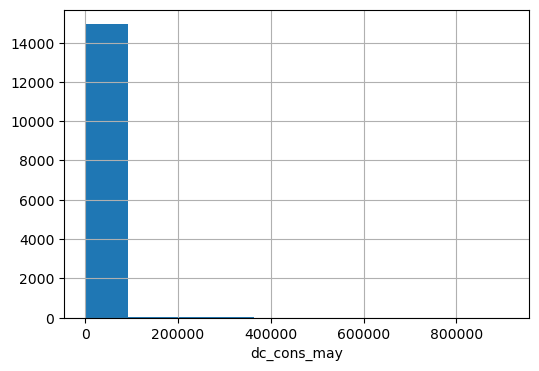

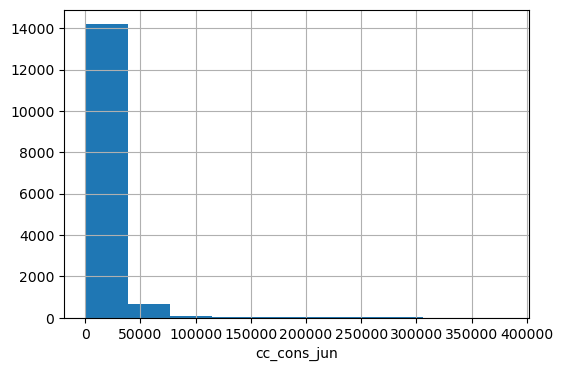

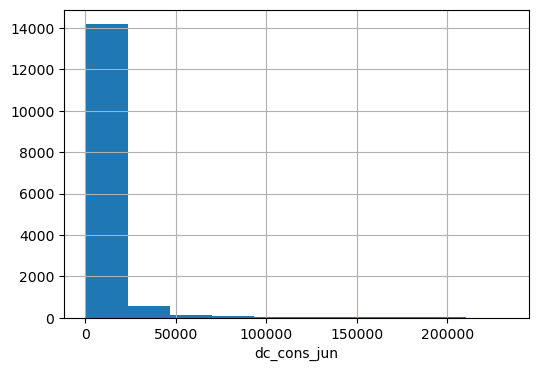

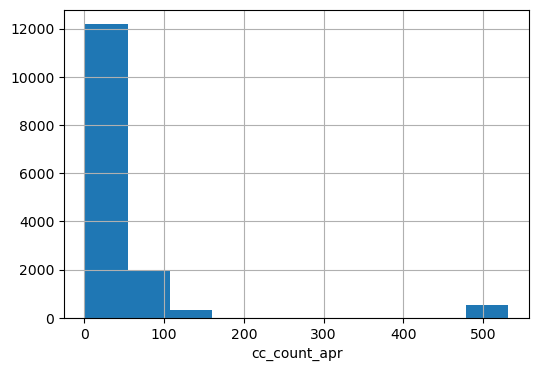

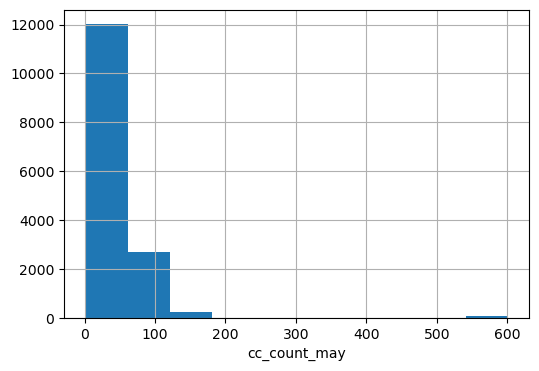

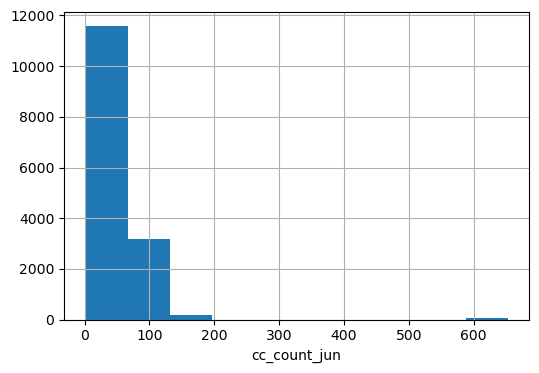

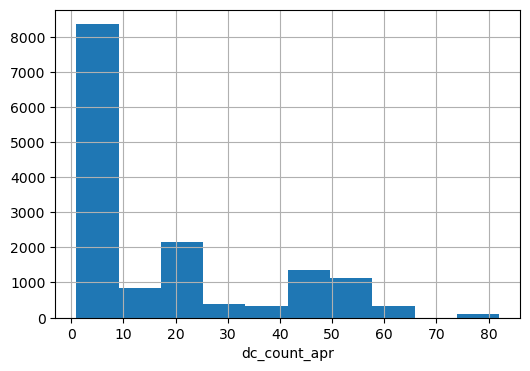

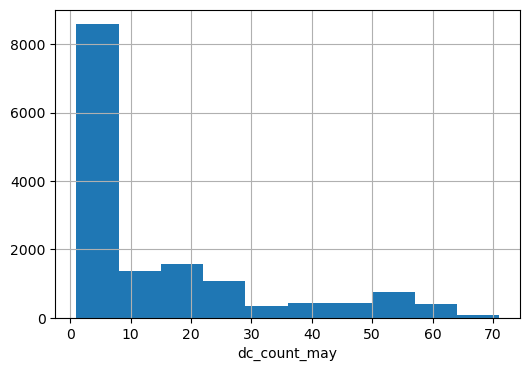

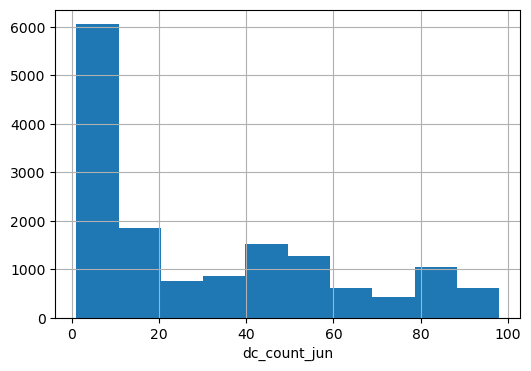

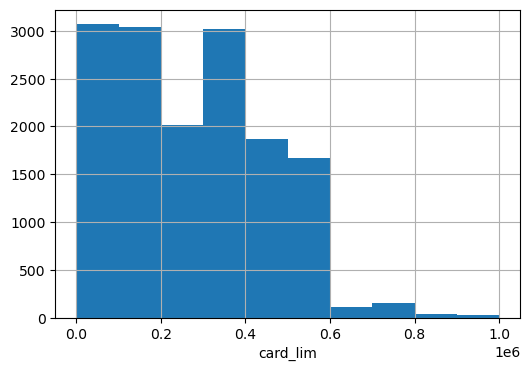

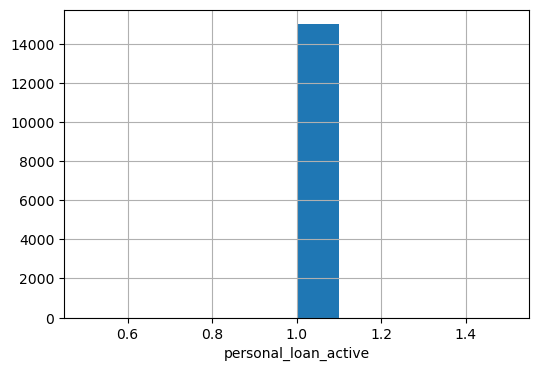

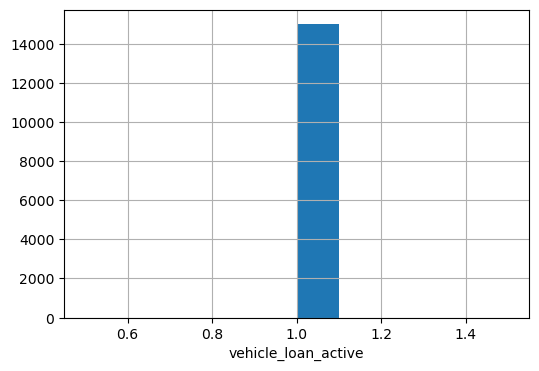

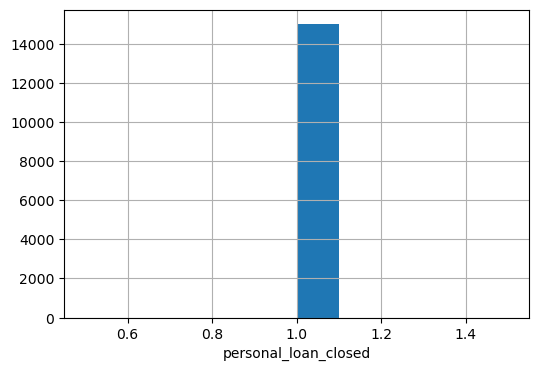

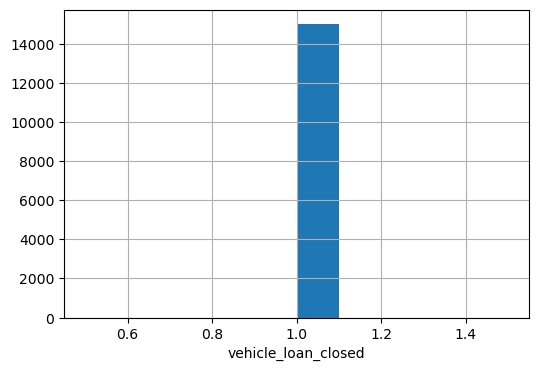

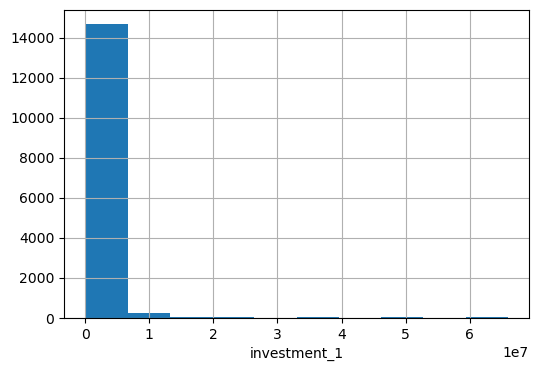

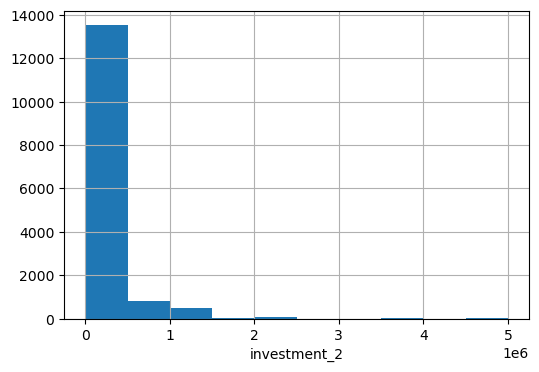

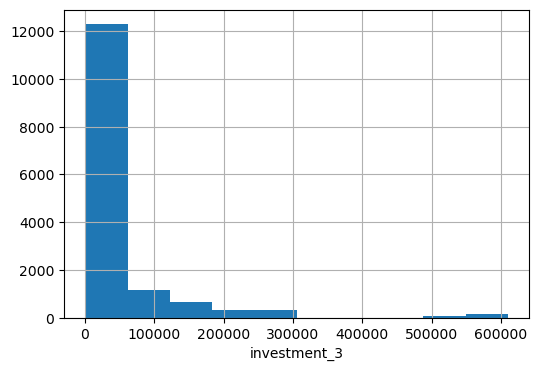

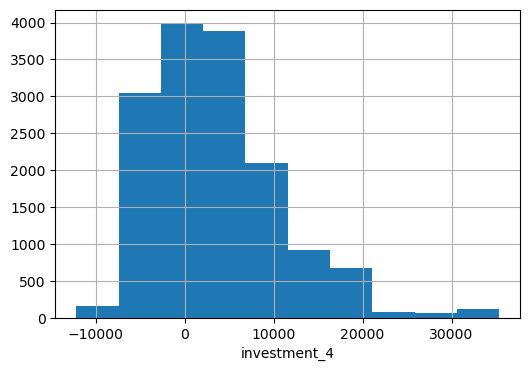

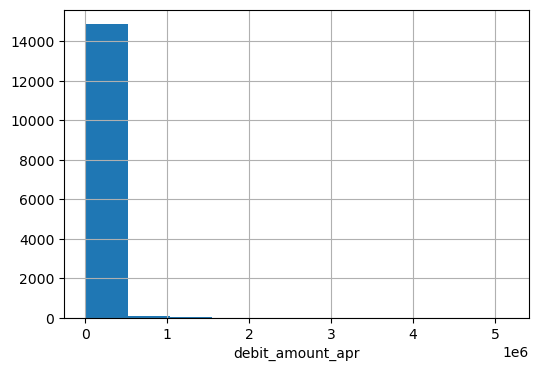

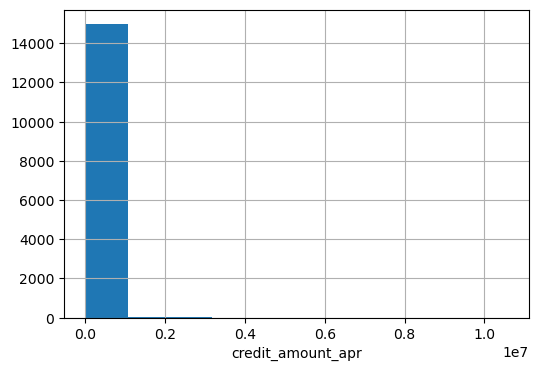

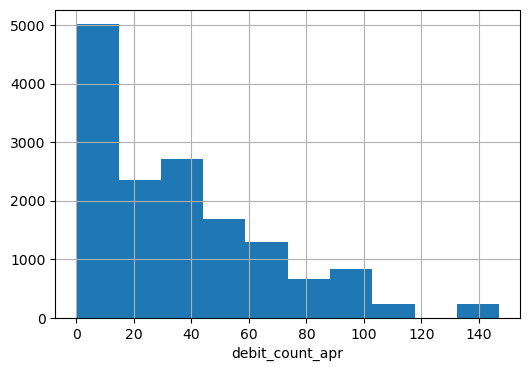

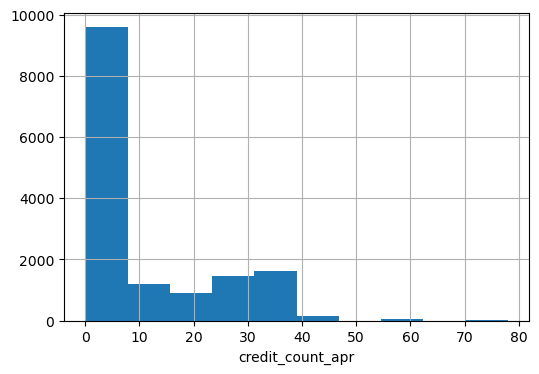

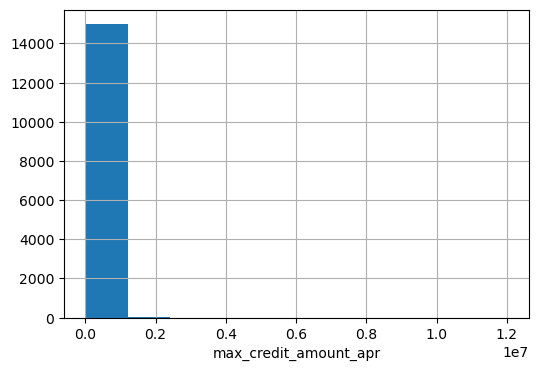

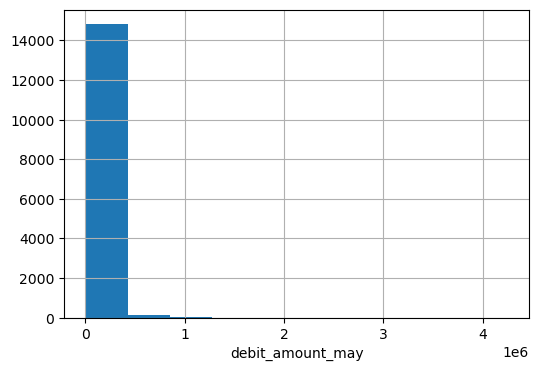

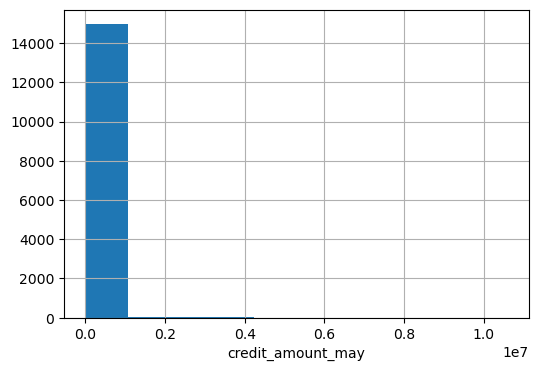

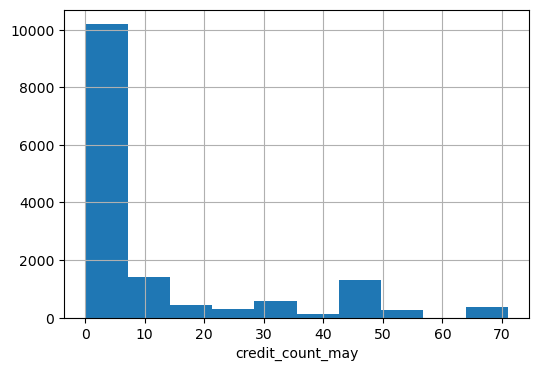

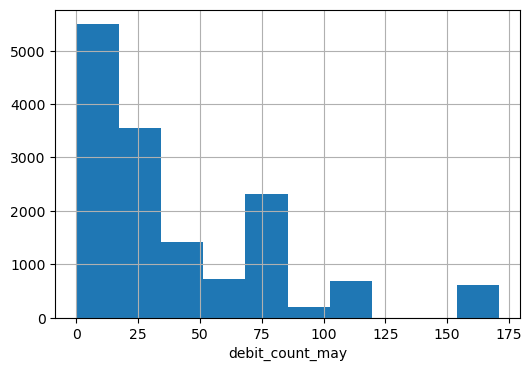

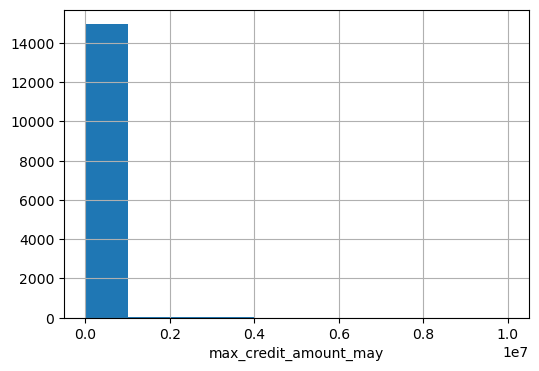

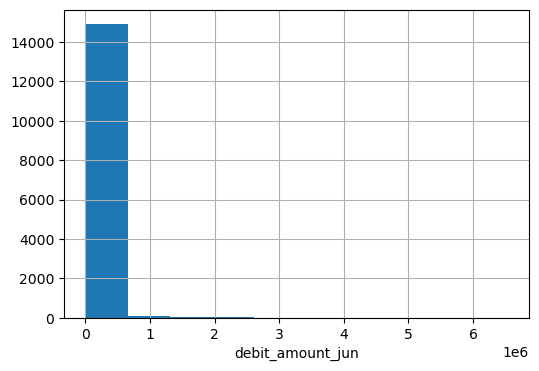

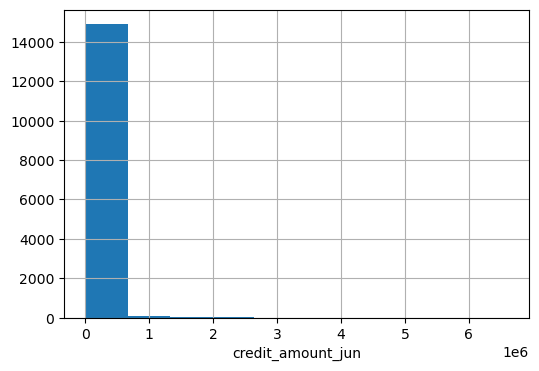

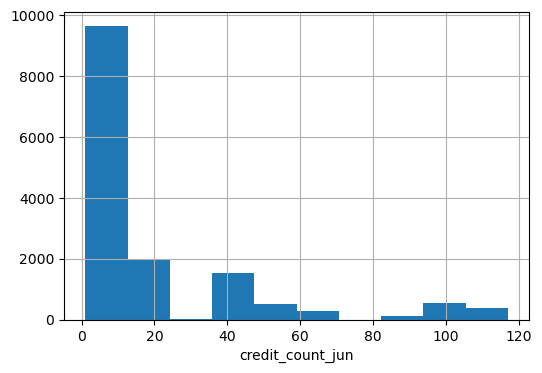

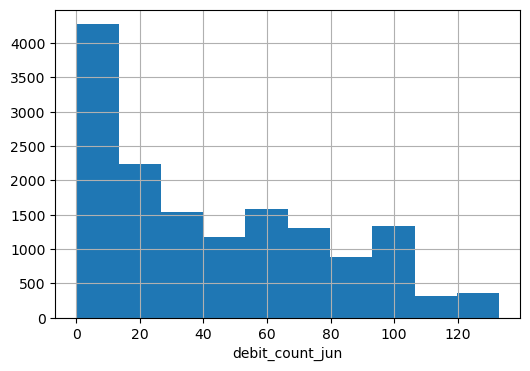

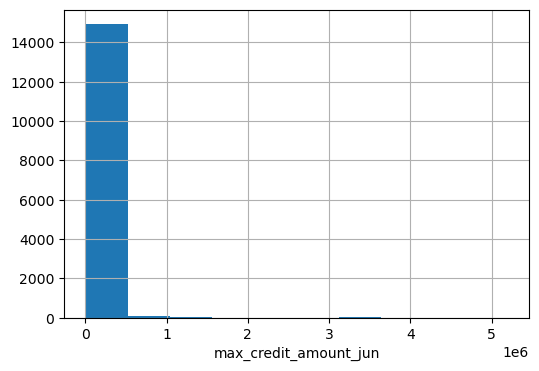

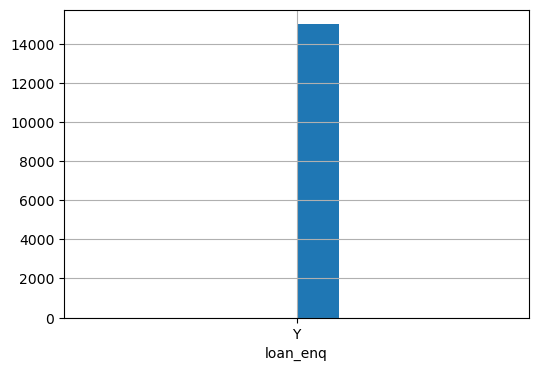

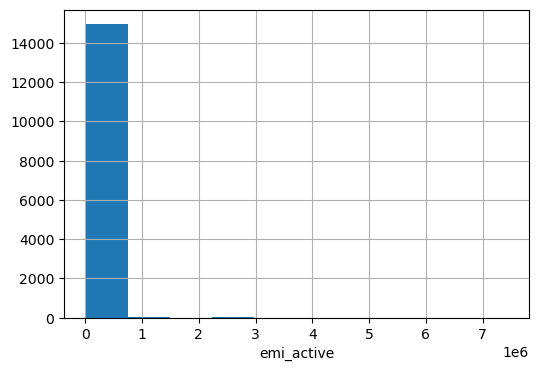

In [39]:
for i in credit_spend_existing.columns:
    credit_spend_existing[i].hist()
    plt.xlabel(str(i))
    plt.show()

In [40]:
credit_spend_existing.nunique()

ID                              15000
cc_cons                         14998
account_type                        2
gender                              2
age                                43
Income                              3
Emp_Tenure_Years                  270
Tenure_with_Bank                   10
region_code                        10
NetBanking_Flag                   210
Avg_days_between_transaction        2
cc_cons_apr                      7408
dc_cons_apr                      3638
cc_cons_may                      7461
dc_cons_may                      3786
cc_cons_jun                      6525
dc_cons_jun                      2874
cc_count_apr                       50
cc_count_may                       58
cc_count_jun                       67
dc_count_apr                       41
dc_count_may                       39
dc_count_jun                       54
card_lim                          308
personal_loan_active                1
vehicle_loan_active                 1
personal_loa

In [41]:
#Bivariate Analysis
#It involves the analysis of two variables, for the purpose of determining the empirical relationship between them.

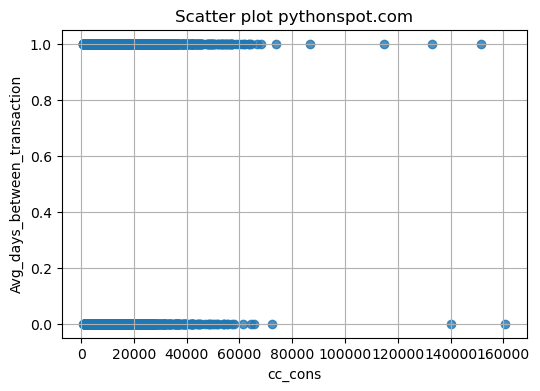

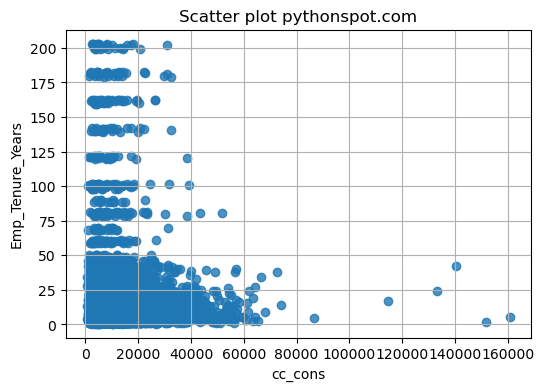

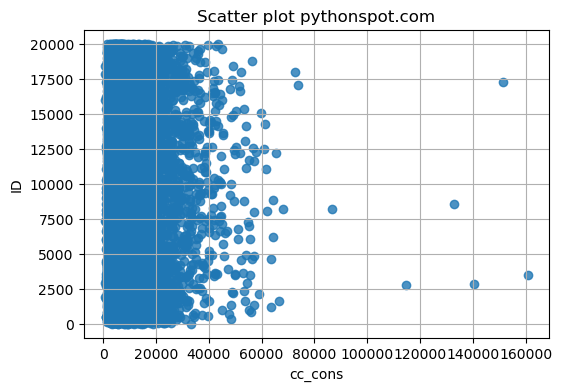

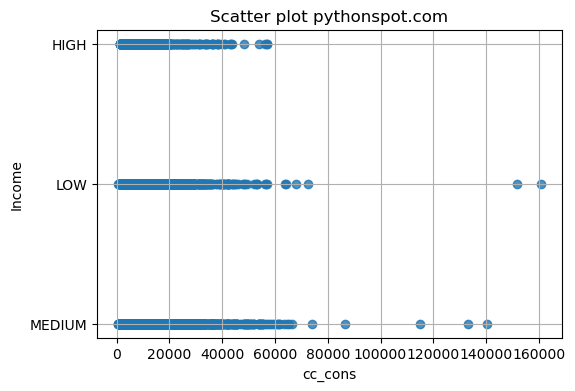

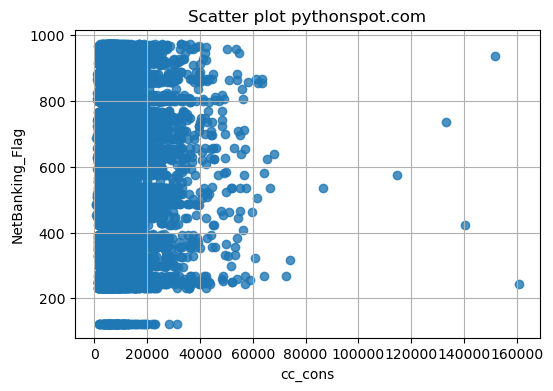

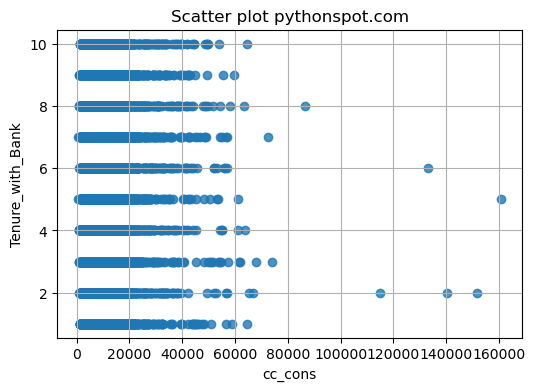

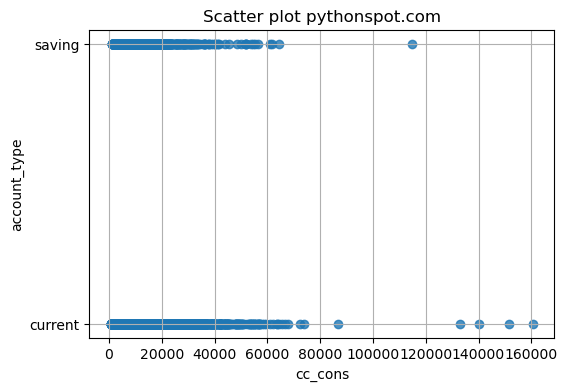

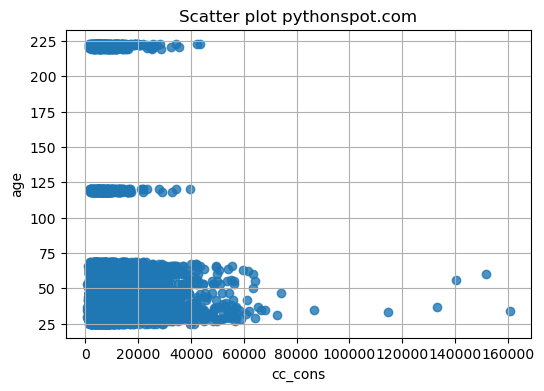

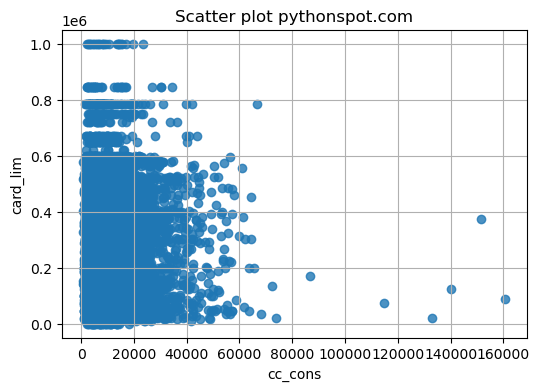

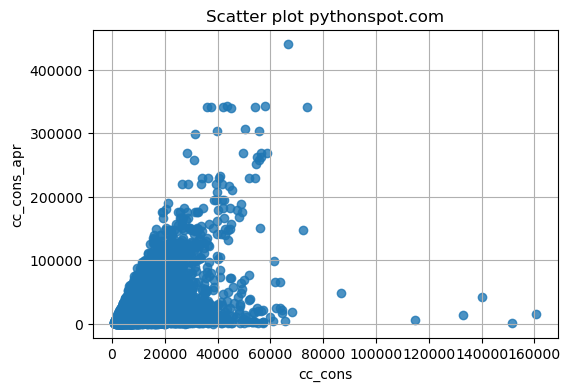

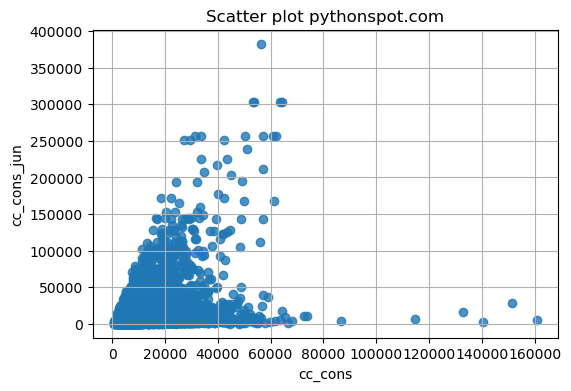

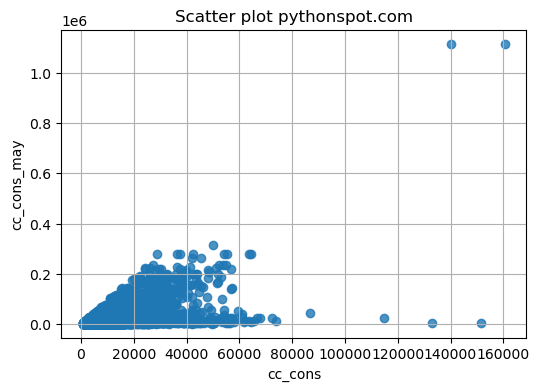

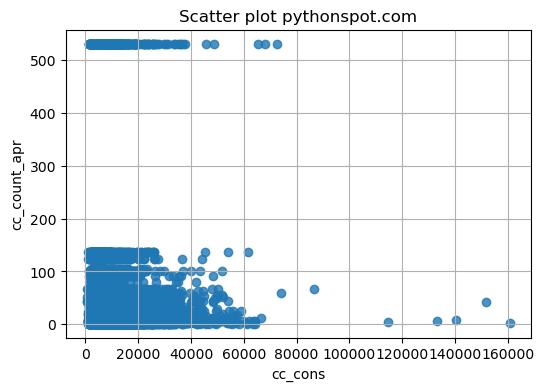

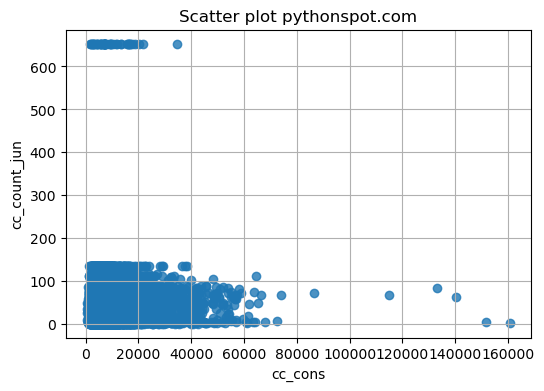

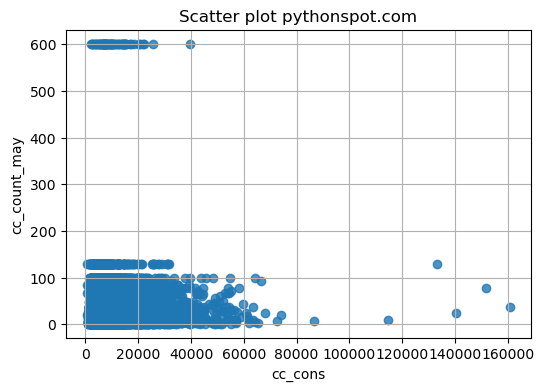

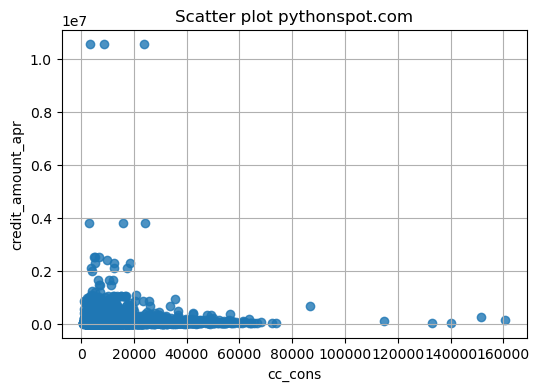

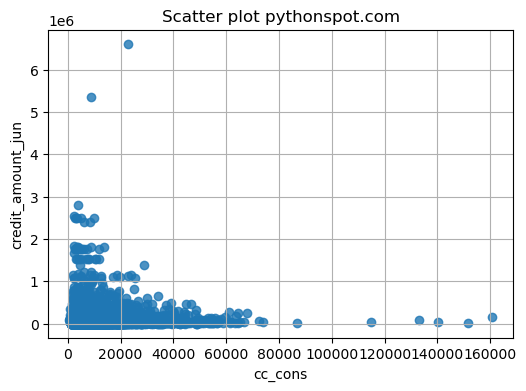

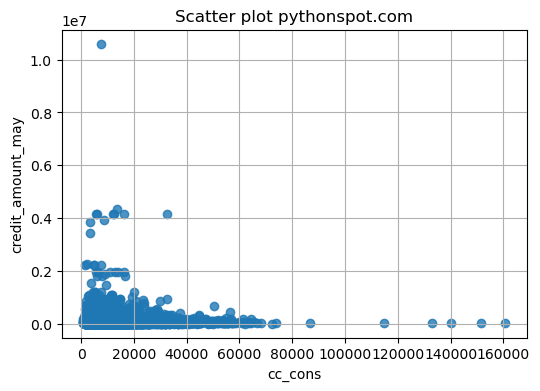

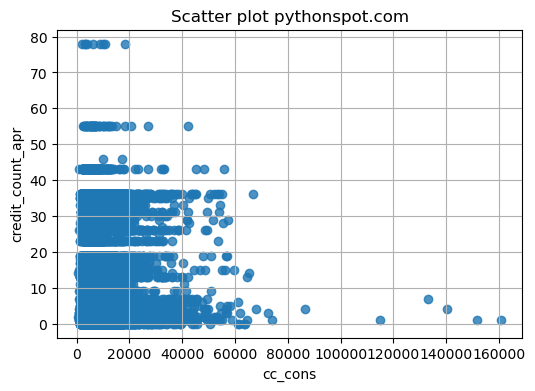

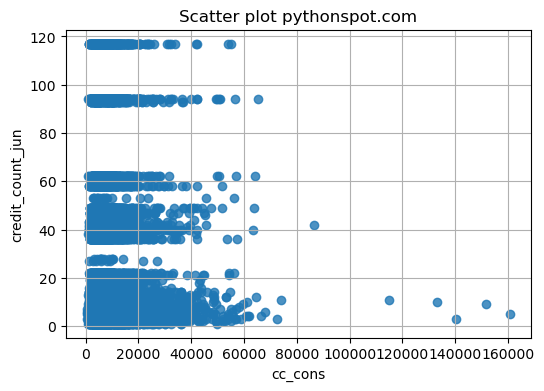

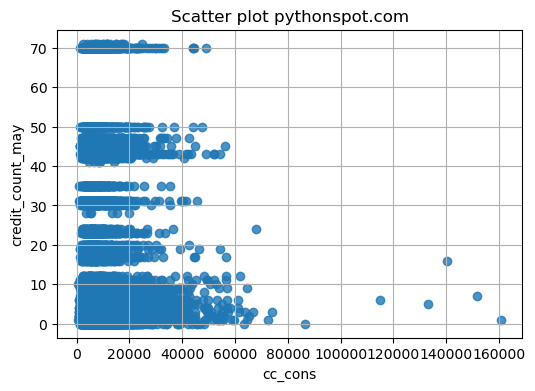

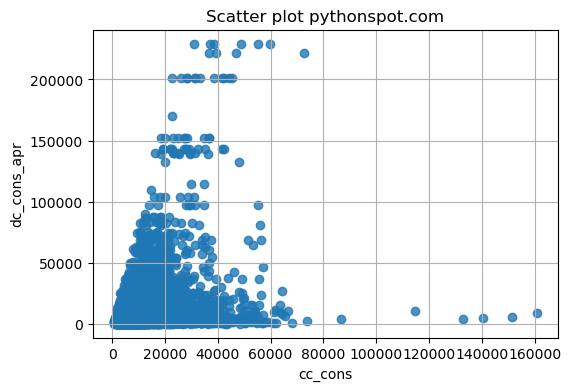

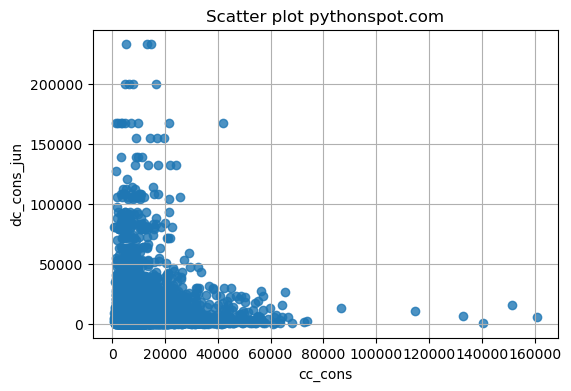

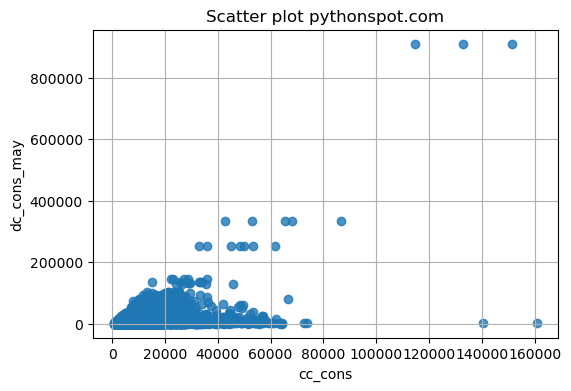

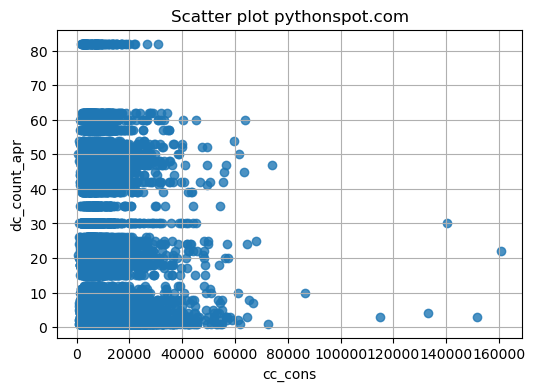

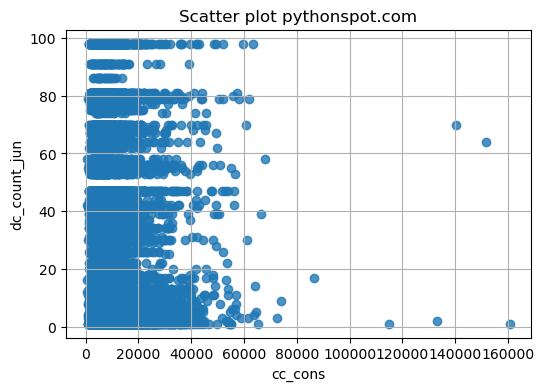

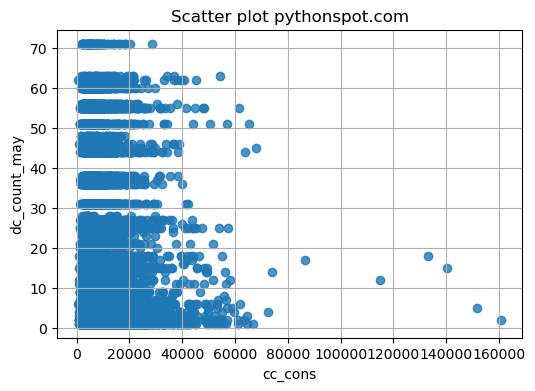

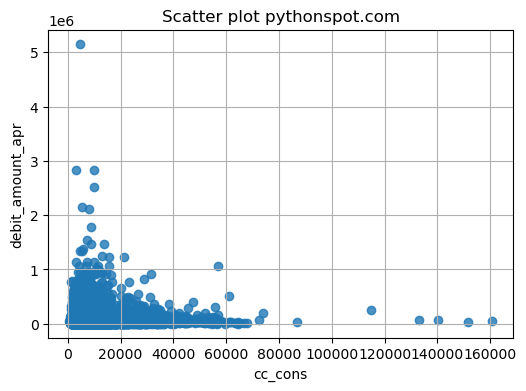

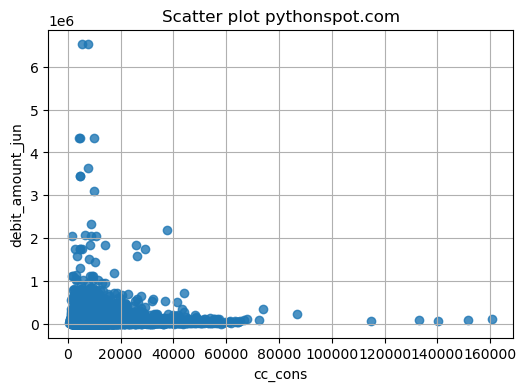

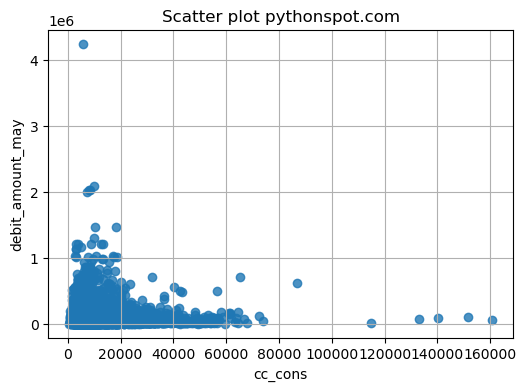

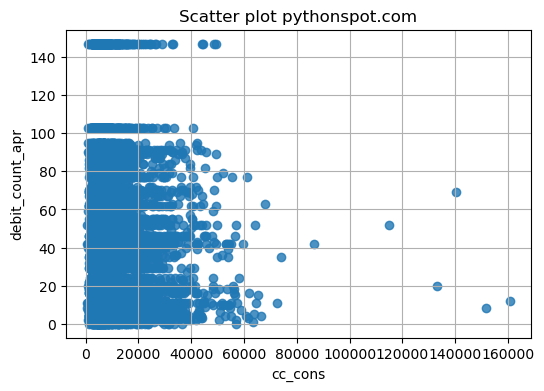

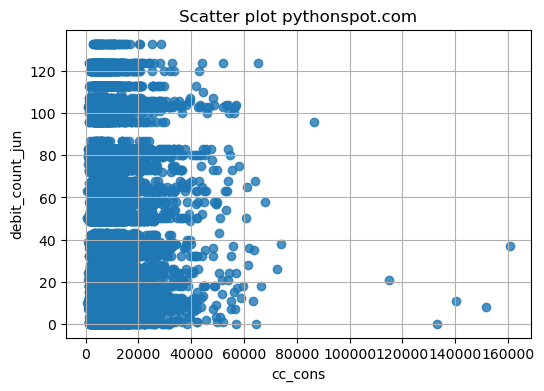

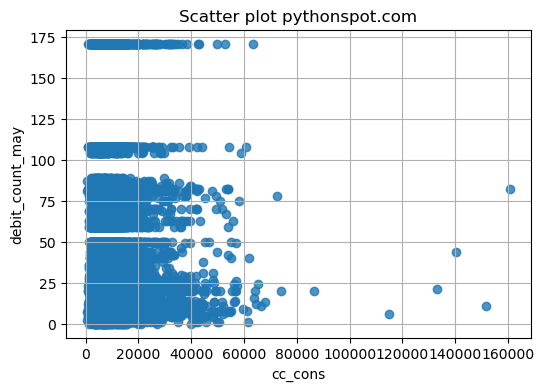

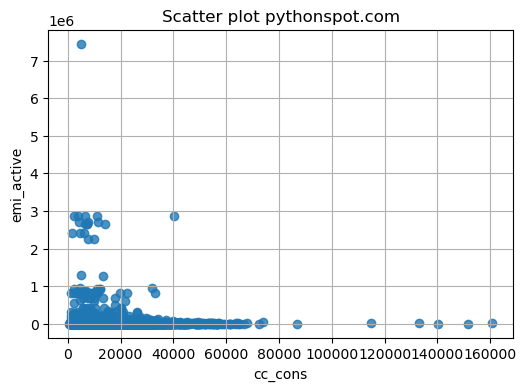

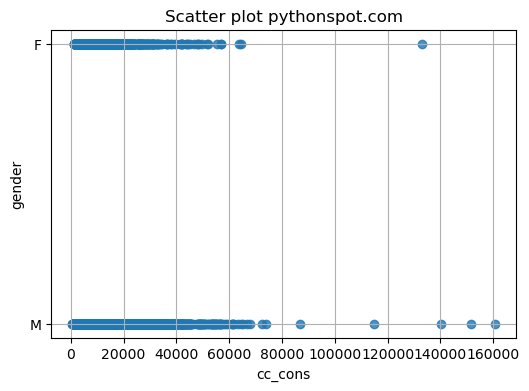

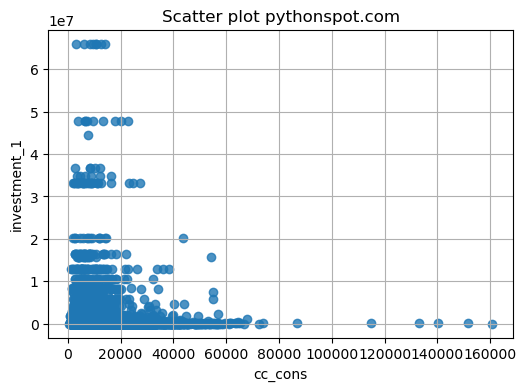

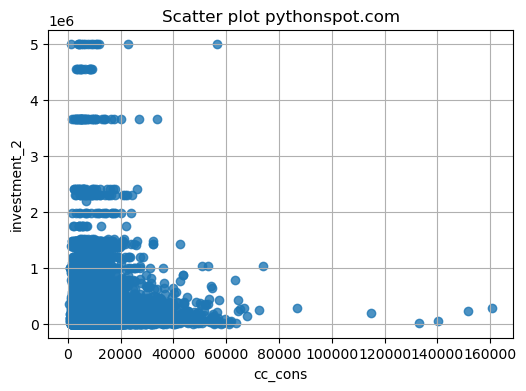

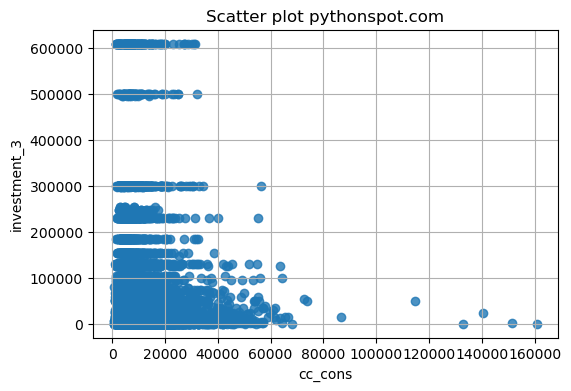

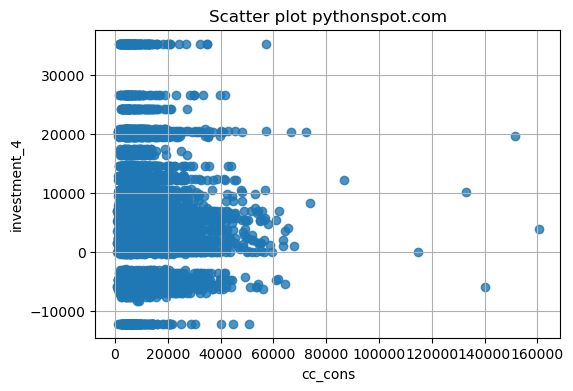

TypeError: 'value' must be an instance of str or bytes, not a float

In [42]:
# Checking Bi-Variate Relationship with taget variable
for i in credit_spend_existing.columns.difference(['cc_cons']):
    plt.scatter(credit_spend_existing.cc_cons,credit_spend_existing[i], alpha=0.8)
    plt.title('Scatter plot pythonspot.com')
    plt.xlabel('cc_cons')
    plt.ylabel(str(i))
    plt.show()  

In [ ]:
#import pandas_profiling
##profile_report= pandas_profiling.ProfileReport(credit_spend_existing)
#profile_report.to_file('profileReport.html')
#Insights from Pandas_Profiling
#1. 'ID'has most unique varible,we can drop it
#2. 

In [ ]:
credit_spend_existing.head()

In [ ]:
credit_spend_existing.shape

In [ ]:
credit_spend_existing.describe()

In [ ]:
credit_spend_existing.Income.value_counts().plot(kind= 'bar')

In [ ]:

#Here our Y variable is cc_cons that is credit consumtion is a numerical variable, this problem comes in to regression problem

In [ ]:
#Data Cleaning
#Drop Variables


In [ ]:
credit_spend_existing.drop(["ID"],axis=1, inplace=True) # due to uniqueness of ID variable we drop this variable

In [ ]:
## The Distribution of Y variable should be normally distributed ( Assumption of linear regression)

In [ ]:
sns.distplot(credit_spend_existing.cc_cons)
plt.show()

In [ ]:
credit_spend_existing['ln_cc_cons']= np.log(credit_spend_existing['cc_cons']+1)
sns.distplot(credit_spend_existing.ln_cc_cons)
plt.show()

In [ ]:
credit_spend_existing.columns

In [ ]:
# Creating Categorical List= Containsb categorical variables.

In [ ]:
for x in ['account_type','gender', 'Income','loan_enq']:
    credit_spend_existing[x]=credit_spend_existing[x].astype('object')

In [92]:
#Separate numerical and categorical variable
#To do that you need to apply for loop along with if condition.

In [93]:
# Find numerical variable in Data frame.
# This will return a list
numeric_var_names = [key for key in dict(credit_spend_existing.dtypes) if dict(credit_spend_existing.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]

# Find Categorical variable in Data frame
cat_var_names = [key for key in dict(credit_spend_existing.dtypes) if dict(credit_spend_existing.dtypes)[key] in ['object']]

#Print the data frame
print( numeric_var_names)
print(cat_var_names)

['ID', 'cc_cons', 'age', 'Emp_Tenure_Years', 'Tenure_with_Bank', 'region_code', 'NetBanking_Flag', 'Avg_days_between_transaction', 'cc_cons_apr', 'dc_cons_apr', 'cc_cons_may', 'dc_cons_may', 'cc_cons_jun', 'dc_cons_jun', 'cc_count_apr', 'cc_count_may', 'cc_count_jun', 'dc_count_apr', 'dc_count_may', 'dc_count_jun', 'card_lim', 'personal_loan_active', 'vehicle_loan_active', 'personal_loan_closed', 'vehicle_loan_closed', 'investment_1', 'investment_2', 'investment_3', 'investment_4', 'debit_amount_apr', 'credit_amount_apr', 'debit_count_apr', 'credit_count_apr', 'max_credit_amount_apr', 'debit_amount_may', 'credit_amount_may', 'credit_count_may', 'debit_count_may', 'max_credit_amount_may', 'debit_amount_jun', 'credit_amount_jun', 'credit_count_jun', 'debit_count_jun', 'max_credit_amount_jun', 'emi_active']
['account_type', 'gender', 'Income', 'loan_enq']


In [94]:
#Convert a list in to dataframe 
#Information about numericvariable in custdata_df

credit_spend_existing_num=credit_spend_existing[numeric_var_names]
credit_spend_existing_num.head(5)

,ID,cc_cons,age,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,personal_loan_active,vehicle_loan_active,personal_loan_closed,vehicle_loan_closed,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active
0,17051,16239.0,30,26.4,9,9,355,0,2017.46,29066.66,15919.84,2197.00,3752.000,29798.00,1.0,4,35,6,2,13,345000,1,1,1.0,1,115818.74,158000.0,550.0,4795.0,33855.84,33401.0,70.0,36,135149.22,14282.00,39805.00,47,20,41860.0,32734.75,80959.00,36,9,171200.0,3448.84
1,11491,39002.0,37,14.4,7,7,485,0,7687.00,1308.00,41888.92,2216.92,7060.530,3143.36,2.0,27,50,1,4,14,369000,1,1,1.0,1,137553.95,187788.1,4699.0,-5439.0,32960.00,32339.0,11.0,4,44368.00,21935.71,67100.00,0,8,113367.0,60974.75,495080.00,5,3,15694.0,3812.69
2,7433,21182.0,33,3.2,1,1,764,0,9094.46,14825.95,3087.64,769.59,25602.595,1445.00,44.0,8,47,1,1,30,27000,1,1,1.0,1,55700.00,165970.9,25508.0,6885.0,115190.10,42200.0,62.0,3,19360.00,56317.68,377994.06,2,14,168000.0,425802.96,115707.38,7,58,28058.0,9432.90
3,14606,8123.0,63,10.2,6,6,863,0,3126.00,4616.33,8676.80,5923.00,6717.000,18747.00,4.0,30,1,2,6,70,195000,1,1,1.0,1,10000.00,51000.0,50000.0,20324.0,34921.12,41233.0,90.0,1,58236.00,250858.09,416.57,45,44,57750.0,25537.91,63606.00,12,0,24459.0,144.61
4,8381,28282.0,33,26.4,6,6,523,0,24988.72,10091.23,10132.00,3477.00,4667.000,511.00,2.0,8,5,18,5,22,47000,1,1,1.0,1,11878.60,187788.1,908.0,0.0,41330.04,76582.0,55.0,30,38912.00,176267.55,30820.00,1,2,18405.0,64687.32,62353.35,49,35,31574.0,1887.89


In [95]:
#Convert a list in to dataframe 
#Information about categorical variable in custdata_df

credit_spend_existing_cat=credit_spend_existing[cat_var_names]
credit_spend_existing_cat.head(5)

,account_type,gender,Income,loan_enq
0,current,M,MEDIUM,Y
1,current,M,LOW,Y
2,current,M,MEDIUM,Y
3,current,M,LOW,Y
4,saving,M,MEDIUM,Y


In [96]:
#Creating Data audit Report

In [97]:
# Use a general function that returns multiple values
def var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  x.std(), x.var(), x.min(), x.dropna().quantile(0.01), x.dropna().quantile(0.05),x.dropna().quantile(0.10),x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75), x.dropna().quantile(0.90),x.dropna().quantile(0.95), x.dropna().quantile(0.99),x.max()], 
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

num_summary=credit_spend_existing_num.apply(lambda x: var_summary(x)).T

In [98]:
num_summary

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
ID,15000.0,0.0,1.504812e+08,10032.077067,10054.0000,5.760372e+03,3.318189e+07,1.000,220.99000,1043.95000,2055.90000,5060.5000,10054.0000,15015.2500,18028.100,1.900305e+04,1.980401e+04,1.999800e+04
cc_cons,15000.0,0.0,1.405355e+08,9369.030957,7408.6044,7.552997e+03,5.704777e+07,610.099,1684.08119,2584.08145,3237.77268,4808.6217,7408.6044,11518.8328,17148.781,2.248716e+04,3.875160e+04,1.607359e+05
age,15000.0,0.0,7.168590e+05,47.790600,40.0000,3.063277e+01,9.383664e+02,25.000,27.00000,28.00000,29.00000,33.0000,40.0000,53.0000,64.000,6.600000e+01,2.220000e+02,2.230000e+02
Emp_Tenure_Years,15000.0,0.0,2.277601e+05,15.184007,9.9000,2.031265e+01,4.126037e+02,0.500,0.90000,1.70000,2.70000,5.1000,9.9000,18.0000,31.000,4.000000e+01,1.212000e+02,2.030000e+02
Tenure_with_Bank,15000.0,0.0,8.265000e+04,5.510000,6.0000,2.865783e+00,8.212714e+00,1.000,1.00000,1.00000,2.00000,3.0000,6.0000,8.0000,10.000,1.000000e+01,1.000000e+01,1.000000e+01
region_code,15000.0,0.0,8.265000e+04,5.510000,6.0000,2.865783e+00,8.212714e+00,1.000,1.00000,1.00000,2.00000,3.0000,6.0000,8.0000,10.000,1.000000e+01,1.000000e+01,1.000000e+01
NetBanking_Flag,15000.0,0.0,8.976232e+06,598.415467,623.0000,2.200623e+02,4.842744e+04,123.000,233.00000,249.00000,269.00000,424.0000,623.0000,799.0000,883.000,9.370000e+02,9.680000e+02,9.740000e+02
Avg_days_between_transaction,15000.0,0.0,1.079300e+04,0.719533,1.0000,4.492422e-01,2.018186e-01,0.000,0.00000,0.00000,0.00000,0.0000,1.0000,1.0000,1.000,1.000000e+00,1.000000e+00,1.000000e+00
cc_cons_apr,15000.0,0.0,2.693609e+08,17957.391719,10288.1000,2.518794e+04,6.344323e+08,253.000,658.76690,1239.40000,1918.97000,4411.0275,10288.1000,21405.0000,40998.681,6.015714e+04,1.238253e+05,4.410313e+05
dc_cons_apr,15000.0,0.0,1.225665e+08,8171.098287,3996.9000,1.477303e+04,2.182424e+08,19.350,153.14000,376.00000,658.50000,1634.0000,3996.9000,9339.0200,18435.367,2.783500e+04,6.480400e+04,2.292550e+05


In [99]:
def cat_summary(x):
    return pd.Series([x.count(),x.isnull().sum(),x.value_counts(),x.unique()],
                    index=['N','NMISS','ColumnNames','UniqueValues'])

In [100]:
cat_summary=credit_spend_existing.apply(lambda x:cat_summary(x)).T

In [101]:
cat_summary

,N,NMISS,ColumnNames,UniqueValues
ID,15000,0,ID 17051 1 8744 1 15638 1 9017 1...,"[17051, 11491, 7433, 14606, 8381, 18278, 14847..."
cc_cons,15000,0,cc_cons 5060.7920 2 9402.4850 2 16239....,"[16239.0, 39002.0, 21182.0, 8123.0, 28282.0, 1..."
account_type,15000,0,account_type current 12727 saving 2273...,"[current, saving]"
gender,15000,0,"gender M 12945 F 2055 Name: count, dtyp...","[M, F]"
age,15000,0,age 33 1290 47 921 32 809 53 ...,"[30, 37, 33, 63, 58, 34, 47, 29, 44, 36, 32, 2..."
Income,15000,0,Income MEDIUM 9612 LOW 4188 HIGH ...,"[MEDIUM, LOW, HIGH]"
Emp_Tenure_Years,15000,0,Emp_Tenure_Years 6.0 293 12.0 287 7.2...,"[26.400000000000002, 14.4, 3.2, 10.20000000000..."
Tenure_with_Bank,15000,0,Tenure_with_Bank 7 1562 6 1534 10 1...,"[9, 7, 1, 6, 5, 10, 8, 2, 4, 3]"
region_code,15000,0,region_code 7 1562 6 1534 10 1527 4...,"[9, 7, 1, 6, 5, 10, 8, 2, 4, 3]"
NetBanking_Flag,15000,0,NetBanking_Flag 249 395 867 280 683 2...,"[355, 485, 764, 863, 523, 385, 539, 249, 658, ..."


In [102]:
#Handling Outliers
#There are some extreame high or extream low value which need to rectify so that it will not have impact on our model

In [103]:
#Handling Outliers for numerical data - Through function
credit_spend_existing_num=  credit_spend_existing_num.apply(lambda x: x.clip(lower = x.quantile(0.01), upper = x.quantile(0.99)))

In [104]:
credit_spend_existing_num

,ID,cc_cons,age,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,personal_loan_active,vehicle_loan_active,personal_loan_closed,vehicle_loan_closed,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active
0,17051.0,16239.000000,30,26.4,9,9,355,0,2017.46,29066.66,15919.84,2197.00,3752.000,29798.00,1.0,4,35,6,2,13,345000,1,1,1.0,1,115818.74,158000.00,550.0,4795.00000,33855.84,33401.00,70.0,36,135149.22,14282.00,39805.00,47,20,41860.0,32734.7500,80959.00,36,9,171200.0,3448.84
1,11491.0,38751.599102,37,14.4,7,7,485,0,7687.00,1308.00,41888.92,2216.92,7060.530,3143.36,2.0,27,50,1,4,14,369000,1,1,1.0,1,137553.95,187788.10,4699.0,-5439.00000,32960.00,32339.00,11.0,4,44368.00,21935.71,67100.00,0,8,113367.0,60974.7500,495080.00,5,3,15694.0,3812.69
2,7433.0,21182.000000,33,3.2,1,1,764,0,9094.46,14825.95,3087.64,769.59,25602.595,1445.00,44.0,8,47,1,1,30,27000,1,1,1.0,1,55700.00,165970.90,25508.0,6885.00000,115190.10,42200.00,62.0,3,19360.00,56317.68,377994.06,2,14,168000.0,425802.9600,115707.38,7,58,28058.0,9432.90
3,14606.0,8123.000000,63,10.2,6,6,863,0,3126.00,4616.33,8676.80,5923.00,6717.000,18747.00,4.0,30,1,2,6,70,195000,1,1,1.0,1,10000.00,51000.00,50000.0,20324.00000,34921.12,41233.00,90.0,1,58236.00,250858.09,416.57,45,44,57750.0,25537.9100,63606.00,12,0,24459.0,144.61
4,8381.0,28282.000000,33,26.4,6,6,523,0,24988.72,10091.23,10132.00,3477.00,4667.000,511.00,2.0,8,5,18,5,22,47000,1,1,1.0,1,11878.60,187788.10,908.0,0.00000,41330.04,76582.00,55.0,30,38912.00,176267.55,30820.00,1,2,18405.0,64687.3200,62353.35,49,35,31574.0,1887.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,6995.0,8324.459200,53,3.9,10,10,914,1,6045.34,4526.20,26897.50,5673.83,8885.000,12021.95,4.0,27,3,24,1,4,59000,1,1,1.0,1,41.40,182359.20,2644.0,3323.00000,88739.64,71866.88,69.0,3,14866.00,18317.60,14034.00,1,25,142966.0,517933.0297,349670.00,58,24,80688.0,78966.76
14996,10376.0,3147.608800,44,16.2,4,4,683,1,5387.00,1774.00,11494.92,588.00,3239.000,4086.52,28.0,1,87,57,4,47,483000,1,1,1.0,1,1053411.20,3342.51,48500.0,1245.00000,76293.03,68327.73,95.0,26,9272.00,34111.46,36151.38,3,4,32841.0,222598.1400,131979.75,1,6,60164.0,4762.10
14997,2181.0,11803.986000,37,1.5,10,10,394,0,9577.00,2948.84,49228.00,2445.00,1378.860,24148.83,43.0,32,74,24,60,67,125000,1,1,1.0,1,63247.65,25404.00,24250.0,0.00000,96821.86,62713.00,11.0,43,32548.00,196749.01,79704.72,2,34,21350.0,80930.2100,8005.00,9,18,41702.0,2877.33
14998,18417.0,3640.442000,220,18.9,9,9,647,0,5305.84,1839.01,17903.40,527.17,10829.000,3754.00,66.0,4,84,8,18,2,69000,1,1,1.0,1,45463.00,589.39,68000.0,5773.00000,74555.08,20111.00,11.0,7,17463.00,10745.76,22408.42,2,81,50135.0,16439.9900,69191.43,3,13,239.0,13006.84


In [105]:
#Handling Missing Values
#As we can see in the above audit report some data is missing in numerical data set and some are missing in categorical. We will treat numerical missing data with mean() and categorical data with mode()

In [106]:
#for categorical and continuous variables
credit_spend_existing_num = credit_spend_existing_num.apply(missing_imputation)
credit_spend_existing_num

,ID,cc_cons,age,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,personal_loan_active,vehicle_loan_active,personal_loan_closed,vehicle_loan_closed,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active
0,17051.0,16239.000000,30,26.4,9,9,355,0,2017.46,29066.66,15919.84,2197.00,3752.000,29798.00,1.0,4,35,6,2,13,345000,1,1,1.0,1,115818.74,158000.00,550.0,4795.00000,33855.84,33401.00,70.0,36,135149.22,14282.00,39805.00,47,20,41860.0,32734.7500,80959.00,36,9,171200.0,3448.84
1,11491.0,38751.599102,37,14.4,7,7,485,0,7687.00,1308.00,41888.92,2216.92,7060.530,3143.36,2.0,27,50,1,4,14,369000,1,1,1.0,1,137553.95,187788.10,4699.0,-5439.00000,32960.00,32339.00,11.0,4,44368.00,21935.71,67100.00,0,8,113367.0,60974.7500,495080.00,5,3,15694.0,3812.69
2,7433.0,21182.000000,33,3.2,1,1,764,0,9094.46,14825.95,3087.64,769.59,25602.595,1445.00,44.0,8,47,1,1,30,27000,1,1,1.0,1,55700.00,165970.90,25508.0,6885.00000,115190.10,42200.00,62.0,3,19360.00,56317.68,377994.06,2,14,168000.0,425802.9600,115707.38,7,58,28058.0,9432.90
3,14606.0,8123.000000,63,10.2,6,6,863,0,3126.00,4616.33,8676.80,5923.00,6717.000,18747.00,4.0,30,1,2,6,70,195000,1,1,1.0,1,10000.00,51000.00,50000.0,20324.00000,34921.12,41233.00,90.0,1,58236.00,250858.09,416.57,45,44,57750.0,25537.9100,63606.00,12,0,24459.0,144.61
4,8381.0,28282.000000,33,26.4,6,6,523,0,24988.72,10091.23,10132.00,3477.00,4667.000,511.00,2.0,8,5,18,5,22,47000,1,1,1.0,1,11878.60,187788.10,908.0,0.00000,41330.04,76582.00,55.0,30,38912.00,176267.55,30820.00,1,2,18405.0,64687.3200,62353.35,49,35,31574.0,1887.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,6995.0,8324.459200,53,3.9,10,10,914,1,6045.34,4526.20,26897.50,5673.83,8885.000,12021.95,4.0,27,3,24,1,4,59000,1,1,1.0,1,41.40,182359.20,2644.0,3323.00000,88739.64,71866.88,69.0,3,14866.00,18317.60,14034.00,1,25,142966.0,517933.0297,349670.00,58,24,80688.0,78966.76
14996,10376.0,3147.608800,44,16.2,4,4,683,1,5387.00,1774.00,11494.92,588.00,3239.000,4086.52,28.0,1,87,57,4,47,483000,1,1,1.0,1,1053411.20,3342.51,48500.0,1245.00000,76293.03,68327.73,95.0,26,9272.00,34111.46,36151.38,3,4,32841.0,222598.1400,131979.75,1,6,60164.0,4762.10
14997,2181.0,11803.986000,37,1.5,10,10,394,0,9577.00,2948.84,49228.00,2445.00,1378.860,24148.83,43.0,32,74,24,60,67,125000,1,1,1.0,1,63247.65,25404.00,24250.0,0.00000,96821.86,62713.00,11.0,43,32548.00,196749.01,79704.72,2,34,21350.0,80930.2100,8005.00,9,18,41702.0,2877.33
14998,18417.0,3640.442000,220,18.9,9,9,647,0,5305.84,1839.01,17903.40,527.17,10829.000,3754.00,66.0,4,84,8,18,2,69000,1,1,1.0,1,45463.00,589.39,68000.0,5773.00000,74555.08,20111.00,11.0,7,17463.00,10745.76,22408.42,2,81,50135.0,16439.9900,69191.43,3,13,239.0,13006.84


In [107]:
credit_spend_existing_cat = credit_spend_existing_cat.apply(missing_imputation)
credit_spend_existing_cat

,account_type,gender,Income,loan_enq
0,current,M,MEDIUM,Y
1,current,M,LOW,Y
2,current,M,MEDIUM,Y
3,current,M,LOW,Y
4,saving,M,MEDIUM,Y
...,...,...,...,...
14995,current,F,LOW,Y
14996,current,M,MEDIUM,Y
14997,current,M,MEDIUM,Y
14998,current,M,MEDIUM,Y


In [108]:
#Again check missing values has been treated or not

In [109]:
# Find the total number of missing values in the numerical data i.e custdata_df_num
print ("\nMissing values in numerical data :  ", credit_spend_existing_num.isnull().sum().values.sum())
print ("\nMissing values in categorical data :  ", credit_spend_existing_cat.isnull().sum().values.sum())


Missing values in numerical data :   0

Missing values in categorical data :   0


In [110]:
#Dummy creation for categorical data¶

In [111]:
# We need to create a function for dummy creation
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname)
    col_dummies.drop(col_dummies.columns[0], axis = 1, inplace = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True)
    return df

In [112]:
credit_spend_existing_cat=credit_spend_existing.select_dtypes(include=['object'])
cat_varlist=list(credit_spend_existing_cat.columns)

In [113]:
# For customer_features in categorical features

for c_feature in cat_varlist:
    credit_spend_existing_cat[c_feature]=credit_spend_existing_cat[c_feature].astype('category')
    credit_spend_existing_cat=create_dummies(credit_spend_existing_cat,c_feature)

In [114]:
credit_spend_existing_cat.sample(5)

,account_type_saving,gender_M,Income_LOW,Income_MEDIUM
10938,False,True,True,False
35,False,True,False,True
3615,False,True,False,True
13185,False,False,True,False
707,False,False,False,True


In [115]:
#Merge Numerical and categorical data
#Now we have nice simple clean data for numerical and categorical both data frame, so now we can merge both data set

In [116]:
credit_spend_existing_fin = pd.concat([credit_spend_existing_num, credit_spend_existing_cat], axis=1)

In [117]:
credit_spend_existing_fin.head()

,ID,cc_cons,age,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,personal_loan_active,vehicle_loan_active,personal_loan_closed,vehicle_loan_closed,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,account_type_saving,gender_M,Income_LOW,Income_MEDIUM
0,17051.0,16239.000000,30,26.4,9,9,355,0,2017.46,29066.66,15919.84,2197.00,3752.000,29798.00,1.0,4,35,6,2,13,345000,1,1,1.0,1,115818.74,158000.0,550.0,4795.0,33855.84,33401.0,70.0,36,135149.22,14282.00,39805.00,47,20,41860.0,32734.75,80959.00,36,9,171200.0,3448.84,False,True,False,True
1,11491.0,38751.599102,37,14.4,7,7,485,0,7687.00,1308.00,41888.92,2216.92,7060.530,3143.36,2.0,27,50,1,4,14,369000,1,1,1.0,1,137553.95,187788.1,4699.0,-5439.0,32960.00,32339.0,11.0,4,44368.00,21935.71,67100.00,0,8,113367.0,60974.75,495080.00,5,3,15694.0,3812.69,False,True,True,False
2,7433.0,21182.000000,33,3.2,1,1,764,0,9094.46,14825.95,3087.64,769.59,25602.595,1445.00,44.0,8,47,1,1,30,27000,1,1,1.0,1,55700.00,165970.9,25508.0,6885.0,115190.10,42200.0,62.0,3,19360.00,56317.68,377994.06,2,14,168000.0,425802.96,115707.38,7,58,28058.0,9432.90,False,True,False,True
3,14606.0,8123.000000,63,10.2,6,6,863,0,3126.00,4616.33,8676.80,5923.00,6717.000,18747.00,4.0,30,1,2,6,70,195000,1,1,1.0,1,10000.00,51000.0,50000.0,20324.0,34921.12,41233.0,90.0,1,58236.00,250858.09,416.57,45,44,57750.0,25537.91,63606.00,12,0,24459.0,144.61,False,True,True,False
4,8381.0,28282.000000,33,26.4,6,6,523,0,24988.72,10091.23,10132.00,3477.00,4667.000,511.00,2.0,8,5,18,5,22,47000,1,1,1.0,1,11878.60,187788.1,908.0,0.0,41330.04,76582.0,55.0,30,38912.00,176267.55,30820.00,1,2,18405.0,64687.32,62353.35,49,35,31574.0,1887.89,True,True,False,True


In [205]:
credit_spend_existing_fin.drop('ln_cc_cons', axis= 1, inplace=True)

KeyError: "['ln_cc_cons'] not found in axis"

In [ ]:
credit_spend_existing_fin.shape

In [ ]:
#Explore data and check the variable distribution for linear regression modelling

In [ ]:
# For Linear regressin y(cc_cons) should follow normal distribution
import seaborn as sns
sns.distplot(credit_spend_existing_fin.cc_cons)

In [ ]:
#Now as you can see distribution is right skewed so we need to take log and then plot the graph.

In [ ]:
from scipy import stats
import pylab

stats.probplot(credit_spend_existing_fin.cc_cons, dist="norm", plot=pylab )
pylab.show()

In [119]:
#As we can see above graph our data is not distributed normally perfectly as discussed previously so we will use 
#boxcox techniue to make it perfect normal

In [120]:
from scipy import stats

# transform training data & save lambda value
credit_spend_existing_fin['bc_cc_cons'],fitted_lambda = stats.boxcox(credit_spend_existing_fin['cc_cons']+1)

In [121]:
sns.distplot(credit_spend_existing_fin.bc_cc_cons)

C:\Users\DELL\AppData\Local\Temp\ipykernel_14976\2347339334.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(credit_spend_existing_fin.bc_cc_cons)


<Axes: xlabel='bc_cc_cons', ylabel='Density'>

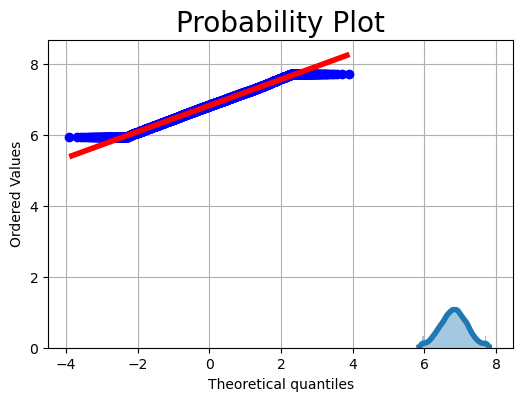

In [122]:
stats.probplot(credit_spend_existing_fin.bc_cc_cons, dist="norm", plot=pylab )
pylab.show()

In [123]:
#Drop the y variables(cc_cons) from dataframe because we are looking correlation between all x variables

#credit_spend_existing_fin.drop(['cc_cons'],axis=1,inplace=True)

In [124]:
credit_spend_existing_fin.drop('bc_cc_cons', axis=1, inplace=True)

In [125]:
credit_spend_existing_fin.columns

Index(['ID', 'cc_cons', 'age', 'Emp_Tenure_Years', 'Tenure_with_Bank', 'region_code', 'NetBanking_Flag', 'Avg_days_between_transaction', 'cc_cons_apr', 'dc_cons_apr', 'cc_cons_may', 'dc_cons_may', 'cc_cons_jun', 'dc_cons_jun', 'cc_count_apr', 'cc_count_may', 'cc_count_jun', 'dc_count_apr', 'dc_count_may', 'dc_count_jun', 'card_lim', 'personal_loan_active', 'vehicle_loan_active', 'personal_loan_closed', 'vehicle_loan_closed', 'investment_1', 'investment_2', 'investment_3', 'investment_4', 'debit_amount_apr', 'credit_amount_apr', 'debit_count_apr', 'credit_count_apr', 'max_credit_amount_apr', 'debit_amount_may', 'credit_amount_may', 'credit_count_may', 'debit_count_may', 'max_credit_amount_may', 'debit_amount_jun', 'credit_amount_jun', 'credit_count_jun', 'debit_count_jun', 'max_credit_amount_jun', 'emi_active', 'account_type_saving', 'gender_M', 'Income_LOW', 'Income_MEDIUM'], dtype='object')

In [126]:
#Devide data into train and test data

In [127]:
#Splitting the data in all x variable and y variable.

feature_columns=credit_spend_existing_fin.columns.difference(['cc_cons'])

In [128]:
feature_columns

Index(['Avg_days_between_transaction', 'Emp_Tenure_Years', 'ID', 'Income_LOW', 'Income_MEDIUM', 'NetBanking_Flag', 'Tenure_with_Bank', 'account_type_saving', 'age', 'card_lim', 'cc_cons_apr', 'cc_cons_jun', 'cc_cons_may', 'cc_count_apr', 'cc_count_jun', 'cc_count_may', 'credit_amount_apr', 'credit_amount_jun', 'credit_amount_may', 'credit_count_apr', 'credit_count_jun', 'credit_count_may', 'dc_cons_apr', 'dc_cons_jun', 'dc_cons_may', 'dc_count_apr', 'dc_count_jun', 'dc_count_may', 'debit_amount_apr', 'debit_amount_jun', 'debit_amount_may', 'debit_count_apr', 'debit_count_jun', 'debit_count_may', 'emi_active', 'gender_M', 'investment_1', 'investment_2', 'investment_3', 'investment_4', 'max_credit_amount_apr', 'max_credit_amount_jun', 'max_credit_amount_may', 'personal_loan_active', 'personal_loan_closed', 'region_code', 'vehicle_loan_active', 'vehicle_loan_closed'], dtype='object')

In [129]:
from sklearn.model_selection import train_test_split

train_x,test_x,train_y,test_y=train_test_split(credit_spend_existing_fin[feature_columns],
                                              credit_spend_existing_fin['cc_cons'],
                                              test_size=0.2,
                                              random_state=12)

In [130]:
print (len(train_x))
print (len(test_x))
print (len(train_y))
print (len(test_y))

12000
3000
12000
3000


In [131]:
#Random Forest Regression Modelling

In [132]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [133]:
RandomForestRegressor?

Init signature:
RandomForestRegressor(
    n_estimators=100,
    *,
    criterion='squared_error',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=1.0,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None,
    monotonic_cst=None,
)
Docstring:     
A random forest regressor.

A random forest is a meta estimator that fits a number of decision tree
regressors on various sub-samples of the dataset and uses averaging to
improve the predictive accuracy and control over-fitting.
Trees in the forest use the best split strategy, i.e. equivalent to passing
`splitter="best"` to the underlying :class:`~sklearn.tree.DecisionTreeRegressor`.
The sub-sample size is controlled with the `max_samples` parameter if
`bootstrap=True` (default), otherwise the whole dataset is use

In [ ]:
param_grid={'n_estimators':np.arange(5,25)}

tree=GridSearchCV(RandomForestRegressor(oob_score=False,warm_start=True),param_grid,cv=2)
tree.fit(train_x,train_y)  

In [ ]:
tree.best_params_ 

In [ ]:
radm_clf = RandomForestRegressor(oob_score=False,n_estimators=12,max_depth=None)
radm_clf.fit( train_x, train_y)

In [ ]:
Prediction task over the test data that is test_x

In [ ]:
# Use the forest's predict method on the test data
pred_y = radm_clf.predict(test_x)

In [ ]:
df = pd.DataFrame({'Real Values':test_y, 'Predicted Values':pred_y})
df

In [ ]:
errors = abs((pred_y - test_y)/test_y)
print('Mean Absolute Percentage Error:', round(np.mean(errors), 5)) 

In [ ]:
rmspe = np.sqrt(np.mean(np.square(((test_y - pred_y) / test_y)), axis=0))
print('Root Mean Squared Percentage Error (RMSPE)::', rmspe)

In [ ]:
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(test_y, pred_y))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(test_y, pred_y))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(test_y, pred_y, squared=False))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(test_y, pred_y))
print('Explained Variance Score:', metrics.explained_variance_score(test_y, pred_y))
print('Max Error:', metrics.max_error(test_y, pred_y))
print('Mean Squared Log Error:', metrics.mean_squared_log_error(test_y, pred_y))
print('Median Absolute Error:', metrics.median_absolute_error(test_y, pred_y))
print('R^2:', metrics.r2_score(test_y, pred_y))
print('Mean Poisson Deviance:', metrics.mean_poisson_deviance(test_y, pred_y))
print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(test_y, pred_y))

In [ ]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_y)

In [ ]:
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

In [ ]:
## After building model we will apply our new model on new datasets that is credit_spend_new 

In [ ]:
#TEST ON NEW DATASETS "CREDIT_SPEND_NEW"
#Firstly for testing the model on new datasets, we have to do some data preprocessing steps as did earlier for the modelling purpose.

In [162]:
credit_spend_new.head()

,ID,cc_cons,account_type,gender,age,Income,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,personal_loan_active,vehicle_loan_active,personal_loan_closed,vehicle_loan_closed,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,loan_enq,emi_active
15000,17591,NaN,current,M,37,MEDIUM,11.9,4,4,575,1,2795.45,1290.0,6141.05,676.50,9146.10,15479.00,4.0,10,4,47,56,6,125000,1,1,1.0,1,13.80,376600.50,1633.0,-5715.49023,27646.84,44341.00,16.0,36,24485.0,23512.67,41755.0,24,20,9750.0,30527.88,31271.00,3,12,25945.92,Y,1170.49
15001,13541,NaN,current,M,33,MEDIUM,7.8,6,6,394,0,29405.13,1640.0,1670.00,2463.92,10947.50,956.00,3.0,10,4,50,38,31,59000,1,1,1.0,1,101891.25,470000.00,891.0,35346.00000,32247.25,21946.00,42.0,5,3375.0,15049.44,130299.0,43,40,16967.0,14342.83,16582.00,6,39,12214.00,Y,16447.45
15002,13431,NaN,current,M,53,LOW,33.0,10,10,324,1,5985.20,6189.0,2696.09,766.00,716.00,4133.22,7.0,30,5,24,27,2,49999,1,1,1.0,1,53374.97,674291.83,54101.0,2557.00000,63169.00,36616.50,41.0,6,14950.0,133659.00,40422.0,42,35,36398.0,32503.16,33539.54,5,9,13215.00,Y,2622.28
15003,8687,NaN,current,M,33,MEDIUM,7.8,5,5,370,1,2105.93,18225.0,34763.56,167.00,4260.27,20185.00,1.0,99,71,5,1,11,520000,1,1,1.0,1,9118.35,470000.00,5905.0,5464.00000,39442.80,43173.38,46.0,1,235844.0,99686.03,48148.0,3,5,97825.0,93572.42,109429.75,21,0,72317.00,Y,340.79
15004,14727,NaN,current,M,62,LOW,12.6,9,9,505,1,3269.00,3532.0,3158.40,2699.77,3373.48,5120.00,2.0,10,47,5,25,1,152000,1,1,1.0,1,12850544.36,101.24,130000.0,1332.00000,8937.00,15232.00,11.0,1,14495.0,190374.25,25926.0,70,75,27936.0,19011.50,41401.00,6,35,42344.00,Y,2812.20


In [163]:
credit_spend_new.drop(['cc_cons','ID'],axis=1, inplace= True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_14976\624370847.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  credit_spend_new.drop(['cc_cons','ID'],axis=1, inplace= True)


In [164]:
# Creating Categorical List= Containsb categorical variables...

In [165]:
for x in ['account_type','gender', 'Income','loan_enq']:
    credit_spend_new[x]=credit_spend_new[x].astype('object')

C:\Users\DELL\AppData\Local\Temp\ipykernel_14976\3255829753.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  credit_spend_new[x]=credit_spend_new[x].astype('object')
C:\Users\DELL\AppData\Local\Temp\ipykernel_14976\3255829753.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  credit_spend_new[x]=credit_spend_new[x].astype('object')
C:\Users\DELL\AppData\Local\Temp\ipykernel_14976\3255829753.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [166]:
#Separate numerical and categorical variable for new datasets

In [167]:
### To do that you need to apply for loop along with if condition.

In [168]:
# Find numerical variable in Data frame.
# This will return a list
numeric_var_names = [key for key in dict(credit_spend_new.dtypes) if dict(credit_spend_new.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]

# Find Categorical variable in Data frame
cat_var_names = [key for key in dict(credit_spend_new.dtypes) if dict(credit_spend_new.dtypes)[key] in ['object']]

#Print the data frame
print( numeric_var_names)
print(cat_var_names)

['age', 'Emp_Tenure_Years', 'Tenure_with_Bank', 'region_code', 'NetBanking_Flag', 'Avg_days_between_transaction', 'cc_cons_apr', 'dc_cons_apr', 'cc_cons_may', 'dc_cons_may', 'cc_cons_jun', 'dc_cons_jun', 'cc_count_apr', 'cc_count_may', 'cc_count_jun', 'dc_count_apr', 'dc_count_may', 'dc_count_jun', 'card_lim', 'personal_loan_active', 'vehicle_loan_active', 'personal_loan_closed', 'vehicle_loan_closed', 'investment_1', 'investment_2', 'investment_3', 'investment_4', 'debit_amount_apr', 'credit_amount_apr', 'debit_count_apr', 'credit_count_apr', 'max_credit_amount_apr', 'debit_amount_may', 'credit_amount_may', 'credit_count_may', 'debit_count_may', 'max_credit_amount_may', 'debit_amount_jun', 'credit_amount_jun', 'credit_count_jun', 'debit_count_jun', 'max_credit_amount_jun', 'emi_active']
['account_type', 'gender', 'Income', 'loan_enq']


In [169]:
#Convert a list in to dataframe 
#Information about numericvariable in credit_spend_new_num

credit_spend_new_num=credit_spend_new[numeric_var_names]
credit_spend_new_num.head(5)

,age,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,personal_loan_active,vehicle_loan_active,personal_loan_closed,vehicle_loan_closed,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active
15000,37,11.9,4,4,575,1,2795.45,1290.0,6141.05,676.50,9146.10,15479.00,4.0,10,4,47,56,6,125000,1,1,1.0,1,13.80,376600.50,1633.0,-5715.49023,27646.84,44341.00,16.0,36,24485.0,23512.67,41755.0,24,20,9750.0,30527.88,31271.00,3,12,25945.92,1170.49
15001,33,7.8,6,6,394,0,29405.13,1640.0,1670.00,2463.92,10947.50,956.00,3.0,10,4,50,38,31,59000,1,1,1.0,1,101891.25,470000.00,891.0,35346.00000,32247.25,21946.00,42.0,5,3375.0,15049.44,130299.0,43,40,16967.0,14342.83,16582.00,6,39,12214.00,16447.45
15002,53,33.0,10,10,324,1,5985.20,6189.0,2696.09,766.00,716.00,4133.22,7.0,30,5,24,27,2,49999,1,1,1.0,1,53374.97,674291.83,54101.0,2557.00000,63169.00,36616.50,41.0,6,14950.0,133659.00,40422.0,42,35,36398.0,32503.16,33539.54,5,9,13215.00,2622.28
15003,33,7.8,5,5,370,1,2105.93,18225.0,34763.56,167.00,4260.27,20185.00,1.0,99,71,5,1,11,520000,1,1,1.0,1,9118.35,470000.00,5905.0,5464.00000,39442.80,43173.38,46.0,1,235844.0,99686.03,48148.0,3,5,97825.0,93572.42,109429.75,21,0,72317.00,340.79
15004,62,12.6,9,9,505,1,3269.00,3532.0,3158.40,2699.77,3373.48,5120.00,2.0,10,47,5,25,1,152000,1,1,1.0,1,12850544.36,101.24,130000.0,1332.00000,8937.00,15232.00,11.0,1,14495.0,190374.25,25926.0,70,75,27936.0,19011.50,41401.00,6,35,42344.00,2812.20


In [170]:
credit_spend_new_cat=credit_spend_new[cat_var_names]
credit_spend_new_cat.head(5)

,account_type,gender,Income,loan_enq
15000,current,M,MEDIUM,Y
15001,current,M,MEDIUM,Y
15002,current,M,LOW,Y
15003,current,M,MEDIUM,Y
15004,current,M,LOW,Y


In [171]:
#Handling Outliers

In [172]:
#Handling Outliers for numerical data - Through function
credit_spend_new_num=  credit_spend_new_num.apply(lambda x: x.clip(lower = x.quantile(0.01), upper = x.quantile(0.99)))

In [173]:
#Handling Missing Values

In [174]:
#for categorical and continuous variables
credit_spend_new_num = credit_spend_new_num.apply(missing_imputation)
credit_spend_new_num

,age,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,personal_loan_active,vehicle_loan_active,personal_loan_closed,vehicle_loan_closed,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active
15000,37,11.9,4,4,575,1,2795.450,1290.00,6141.05,676.50,9146.10,15479.00,4.0,10,4,47,56,6,125000,1,1,1.0,1,13.80,376600.50,1633.0,-5715.49023,27646.84,44341.00,16.0,36,24485.0,23512.67,41755.00,24,20,9750.0,30527.88,31271.00,3,12,25945.92,1170.49
15001,33,7.8,6,6,394,0,29405.130,1640.00,1670.00,2463.92,10947.50,956.00,3.0,10,4,50,38,31,59000,1,1,1.0,1,101891.25,470000.00,891.0,26601.00000,32247.25,21946.00,42.0,5,3375.0,15049.44,130299.00,43,40,16967.0,14342.83,16582.00,6,39,12214.00,16447.45
15002,53,33.0,10,10,324,1,5985.200,6189.00,2696.09,766.00,716.00,4133.22,7.0,30,5,24,27,2,49999,1,1,1.0,1,53374.97,674291.83,54101.0,2557.00000,63169.00,36616.50,41.0,6,14950.0,133659.00,40422.00,42,35,36398.0,32503.16,33539.54,5,9,13215.00,2622.28
15003,33,7.8,5,5,370,1,2105.930,18225.00,34763.56,167.00,4260.27,20185.00,1.0,99,71,5,1,11,520000,1,1,1.0,1,9118.35,470000.00,5905.0,5464.00000,39442.80,43173.38,46.0,1,235844.0,99686.03,48148.00,3,5,97825.0,93572.42,109429.75,21,0,72317.00,340.79
15004,62,12.6,9,9,505,1,3269.000,3532.00,3158.40,2699.77,3373.48,5120.00,2.0,10,47,5,25,1,152000,1,1,1.0,1,10535967.50,101.24,130000.0,1332.00000,8937.00,15232.00,11.0,1,14495.0,190374.25,25926.00,70,75,27936.0,19011.50,41401.00,6,35,42344.00,2812.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,35,13.5,1,1,523,0,4641.500,5979.58,6008.61,4410.00,41743.00,1884.00,26.0,1,4,1,2,26,595000,1,1,1.0,1,84446.00,961916.90,505.0,553.00000,41314.91,37646.41,6.0,14,27825.0,34952.75,45461.00,35,11,32944.0,105488.53,125470.83,21,50,58037.00,7870.88
19996,53,9.9,7,7,723,1,4994.450,2805.37,23214.00,5870.00,1041.00,1008.73,37.0,56,50,18,1,58,16000,1,1,1.0,1,1892440.00,295150.90,10271.0,20324.00000,216.25,1605.00,32.0,26,27912.0,17261.41,85422.00,5,8,8850.0,77112.66,86559.00,62,38,24110.00,3668.30
19997,62,37.8,8,8,863,1,3262.145,2871.00,7335.25,11774.04,4130.00,1413.00,12.0,77,1,1,2,17,124000,1,1,1.0,1,115.45,200015.58,30000.0,6885.00000,89327.00,80044.00,32.0,14,14580.0,142002.00,68985.86,10,108,35819.0,57192.48,80627.00,2,18,1769.00,5450.34
19998,34,12.6,4,4,882,0,12824.010,4866.00,12242.48,284.00,15132.77,37911.00,67.0,1,4,1,44,67,371000,1,1,1.0,1,48796.45,1631.11,925.0,10455.00000,191780.00,66057.00,40.0,5,23881.0,156995.05,13558.00,11,12,39083.0,82039.00,24332.00,117,64,37255.00,59.29


In [175]:
credit_spend_new_cat = credit_spend_new_cat.apply(missing_imputation)
credit_spend_new_cat

,account_type,gender,Income,loan_enq
15000,current,M,MEDIUM,Y
15001,current,M,MEDIUM,Y
15002,current,M,LOW,Y
15003,current,M,MEDIUM,Y
15004,current,M,LOW,Y
...,...,...,...,...
19995,current,M,MEDIUM,Y
19996,current,M,MEDIUM,Y
19997,current,M,HIGH,Y
19998,current,M,MEDIUM,Y


In [176]:
# Find the total number of missing values in the numerical data i.e custdata_df_num
print ("\nMissing values in numerical data :  ", credit_spend_new_num.isnull().sum().values.sum())
print ("\nMissing values in categorical data :  ", credit_spend_new_cat.isnull().sum().values.sum())


Missing values in numerical data :   0

Missing values in categorical data :   0


In [177]:
#Dummy Creation

In [178]:
credit_spend_new_cat=credit_spend_new_cat.select_dtypes(include=['object'])
cat_varlist=list(credit_spend_new_cat.columns)

In [179]:
# For customer_features in categorical features

for c_feature in cat_varlist:
    credit_spend_new_cat[c_feature]=credit_spend_new_cat[c_feature].astype('category')
    credit_spend_new_cat=create_dummies(credit_spend_new_cat,c_feature)

In [180]:
credit_spend_new_cat.sample(5)

,account_type_current,account_type_saving,gender_F,gender_M,Income_HIGH,Income_LOW,Income_MEDIUM
15150,True,False,True,False,False,True,False
19696,True,False,False,True,False,True,False
17794,True,False,False,True,False,True,False
17112,True,False,False,True,False,False,True
17186,True,False,False,True,False,True,False


In [181]:
credit_spend_new_fin = pd.concat([credit_spend_new_num, credit_spend_new_cat], axis=1)

In [182]:
credit_spend_new_fin.head()

,age,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,personal_loan_active,vehicle_loan_active,personal_loan_closed,vehicle_loan_closed,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,account_type_current,account_type_saving,gender_F,gender_M,Income_HIGH,Income_LOW,Income_MEDIUM
15000,37,11.9,4,4,575,1,2795.45,1290.0,6141.05,676.50,9146.10,15479.00,4.0,10,4,47,56,6,125000,1,1,1.0,1,13.80,376600.50,1633.0,-5715.49023,27646.84,44341.00,16.0,36,24485.0,23512.67,41755.0,24,20,9750.0,30527.88,31271.00,3,12,25945.92,1170.49,True,False,False,True,False,False,True
15001,33,7.8,6,6,394,0,29405.13,1640.0,1670.00,2463.92,10947.50,956.00,3.0,10,4,50,38,31,59000,1,1,1.0,1,101891.25,470000.00,891.0,26601.00000,32247.25,21946.00,42.0,5,3375.0,15049.44,130299.0,43,40,16967.0,14342.83,16582.00,6,39,12214.00,16447.45,True,False,False,True,False,False,True
15002,53,33.0,10,10,324,1,5985.20,6189.0,2696.09,766.00,716.00,4133.22,7.0,30,5,24,27,2,49999,1,1,1.0,1,53374.97,674291.83,54101.0,2557.00000,63169.00,36616.50,41.0,6,14950.0,133659.00,40422.0,42,35,36398.0,32503.16,33539.54,5,9,13215.00,2622.28,True,False,False,True,False,True,False
15003,33,7.8,5,5,370,1,2105.93,18225.0,34763.56,167.00,4260.27,20185.00,1.0,99,71,5,1,11,520000,1,1,1.0,1,9118.35,470000.00,5905.0,5464.00000,39442.80,43173.38,46.0,1,235844.0,99686.03,48148.0,3,5,97825.0,93572.42,109429.75,21,0,72317.00,340.79,True,False,False,True,False,False,True
15004,62,12.6,9,9,505,1,3269.00,3532.0,3158.40,2699.77,3373.48,5120.00,2.0,10,47,5,25,1,152000,1,1,1.0,1,10535967.50,101.24,130000.0,1332.00000,8937.00,15232.00,11.0,1,14495.0,190374.25,25926.0,70,75,27936.0,19011.50,41401.00,6,35,42344.00,2812.20,True,False,False,True,False,True,False


In [183]:
credit_spend_new_fin.shape

(5000, 50)

In [184]:
#Making prediction on new datasets

In [207]:
# Use the forest's predict method on the test data
pred_cc_cons = radm_clf.predict(credit_spend_new_fin)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Income_HIGH
- account_type_current
- gender_F
- index
- level_0
Feature names seen at fit time, yet now missing:
- ID


In [ ]:
pred_cc_cons=pd.DataFrame(pred_cc_cons.tolist())

In [191]:
pred_cc_cons.columns = ['pred_cc_cons']
pred_cc_cons

NameError: name 'pred_cc_cons' is not defined

In [192]:
credit_spend_new_fin.reset_index(inplace= True)
credit_spend_new_fin

,level_0,index,age,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,personal_loan_active,vehicle_loan_active,personal_loan_closed,vehicle_loan_closed,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,account_type_current,account_type_saving,gender_F,gender_M,Income_HIGH,Income_LOW,Income_MEDIUM
0,0,15000,37,11.9,4,4,575,1,2795.450,1290.00,6141.05,676.50,9146.10,15479.00,4.0,10,4,47,56,6,125000,1,1,1.0,1,13.80,376600.50,1633.0,-5715.49023,27646.84,44341.00,16.0,36,24485.0,23512.67,41755.00,24,20,9750.0,30527.88,31271.00,3,12,25945.92,1170.49,True,False,False,True,False,False,True
1,1,15001,33,7.8,6,6,394,0,29405.130,1640.00,1670.00,2463.92,10947.50,956.00,3.0,10,4,50,38,31,59000,1,1,1.0,1,101891.25,470000.00,891.0,26601.00000,32247.25,21946.00,42.0,5,3375.0,15049.44,130299.00,43,40,16967.0,14342.83,16582.00,6,39,12214.00,16447.45,True,False,False,True,False,False,True
2,2,15002,53,33.0,10,10,324,1,5985.200,6189.00,2696.09,766.00,716.00,4133.22,7.0,30,5,24,27,2,49999,1,1,1.0,1,53374.97,674291.83,54101.0,2557.00000,63169.00,36616.50,41.0,6,14950.0,133659.00,40422.00,42,35,36398.0,32503.16,33539.54,5,9,13215.00,2622.28,True,False,False,True,False,True,False
3,3,15003,33,7.8,5,5,370,1,2105.930,18225.00,34763.56,167.00,4260.27,20185.00,1.0,99,71,5,1,11,520000,1,1,1.0,1,9118.35,470000.00,5905.0,5464.00000,39442.80,43173.38,46.0,1,235844.0,99686.03,48148.00,3,5,97825.0,93572.42,109429.75,21,0,72317.00,340.79,True,False,False,True,False,False,True
4,4,15004,62,12.6,9,9,505,1,3269.000,3532.00,3158.40,2699.77,3373.48,5120.00,2.0,10,47,5,25,1,152000,1,1,1.0,1,10535967.50,101.24,130000.0,1332.00000,8937.00,15232.00,11.0,1,14495.0,190374.25,25926.00,70,75,27936.0,19011.50,41401.00,6,35,42344.00,2812.20,True,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,19995,35,13.5,1,1,523,0,4641.500,5979.58,6008.61,4410.00,41743.00,1884.00,26.0,1,4,1,2,26,595000,1,1,1.0,1,84446.00,961916.90,505.0,553.00000,41314.91,37646.41,6.0,14,27825.0,34952.75,45461.00,35,11,32944.0,105488.53,125470.83,21,50,58037.00,7870.88,True,False,False,True,False,False,True
4996,4996,19996,53,9.9,7,7,723,1,4994.450,2805.37,23214.00,5870.00,1041.00,1008.73,37.0,56,50,18,1,58,16000,1,1,1.0,1,1892440.00,295150.90,10271.0,20324.00000,216.25,1605.00,32.0,26,27912.0,17261.41,85422.00,5,8,8850.0,77112.66,86559.00,62,38,24110.00,3668.30,True,False,False,True,False,False,True
4997,4997,19997,62,37.8,8,8,863,1,3262.145,2871.00,7335.25,11774.04,4130.00,1413.00,12.0,77,1,1,2,17,124000,1,1,1.0,1,115.45,200015.58,30000.0,6885.00000,89327.00,80044.00,32.0,14,14580.0,142002.00,68985.86,10,108,35819.0,57192.48,80627.00,2,18,1769.00,5450.34,True,False,False,True,True,False,False
4998,4998,19998,34,12.6,4,4,882,0,12824.010,4866.00,12242.48,284.00,15132.77,37911.00,67.0,1,4,1,44,67,371000,1,1,1.0,1,48796.45,1631.11,925.0,10455.00000,191780.00,66057.00,40.0,5,23881.0,156995.05,13558.00,11,12,39083.0,82039.00,24332.00,117,64,37255.00,59.29,True,False,False,True,False,False,True


In [193]:
#Concatenating final prediction with original test file
  
new_data_output = pd.concat([credit_spend_new_fin, pred_cc_cons], axis=1)

new_data_output.head()

NameError: name 'pred_cc_cons' is not defined

In [194]:
new_data_output.to_csv('credit_spend_new_output.csv')

NameError: name 'new_data_output' is not defined

In [195]:
## That is the final output which we want on our new data sets, the predicted credit_consumption for new 5000 customers.

In [196]:
#Feature Importance using Random Forest ( .feature_importances_): Method1

In [197]:
from sklearn import metrics

In [198]:
indices = np.argsort(radm_clf.feature_importances_)[::-1]
feature_rank = pd.DataFrame( columns = ['rank', 'feature', 'importance'] )
for f in range(train_x.shape[1]):
  feature_rank.loc[f] = [f+1,
                         train_x.columns[indices[f]],
                         radm_clf.feature_importances_[indices[f]]]
sns.barplot( y = 'feature', x = 'importance', data = feature_rank )

<Axes: xlabel='importance', ylabel='feature'>

In [199]:
indices = np.argsort(radm_clf.feature_importances_)[::-1]
feature_rank = pd.DataFrame( columns = ['rank', 'feature', 'importance'] )
for f in range(train_x.shape[1]):
  feature_rank.loc[f] = [f+1,
                         train_x.columns[indices[f]],
                         radm_clf.feature_importances_[indices[f]]]

feature_rank

,rank,feature,importance
0,1,cc_cons_may,0.276154
1,2,cc_cons_apr,0.263319
2,3,cc_cons_jun,0.150702
3,4,dc_cons_apr,0.086586
4,5,dc_cons_may,0.079371
5,6,credit_amount_jun,0.006975
6,7,max_credit_amount_jun,0.005709
7,8,ID,0.005666
8,9,debit_count_may,0.005603
9,10,max_credit_amount_apr,0.005503


In [200]:
#Select features and then convert it into list
x=feature_rank.loc[0:75,['feature']]
x=x['feature'].tolist()
print(x)

['cc_cons_may', 'cc_cons_apr', 'cc_cons_jun', 'dc_cons_apr', 'dc_cons_may', 'credit_amount_jun', 'max_credit_amount_jun', 'ID', 'debit_count_may', 'max_credit_amount_apr', 'dc_cons_jun', 'emi_active', 'investment_3', 'card_lim', 'debit_amount_apr', 'debit_amount_jun', 'debit_amount_may', 'Emp_Tenure_Years', 'credit_amount_apr', 'investment_4', 'dc_count_jun', 'investment_2', 'investment_1', 'cc_count_may', 'cc_count_jun', 'debit_count_apr', 'credit_amount_may', 'max_credit_amount_may', 'age', 'cc_count_apr', 'NetBanking_Flag', 'credit_count_jun', 'credit_count_may', 'dc_count_may', 'dc_count_apr', 'debit_count_jun', 'credit_count_apr', 'Tenure_with_Bank', 'region_code', 'Income_MEDIUM', 'gender_M', 'Income_LOW', 'account_type_saving', 'Avg_days_between_transaction', 'vehicle_loan_active', 'personal_loan_active', 'personal_loan_closed', 'vehicle_loan_closed']


In [201]:
# Create data frame with selected features
rf_features=['emi_active', 'cc_cons_may', 'cc_cons_apr', 'cc_cons_jun', 'max_credit_amount_jun', 
             'investment_1', 'debit_amount_may', 'credit_amount_apr', 'max_credit_amount_apr', 
             'dc_cons_jun', 'dc_cons_apr', 'debit_amount_jun', 'max_credit_amount_may',
             'credit_amount_jun', 'debit_amount_apr', 'credit_amount_may', 'dc_cons_may', 
             'investment_3', 'investment_2', 'Emp_Tenure_Years', 'card_lim', 'region_code', 'investment_4',
             'cc_count_jun', 
             'debit_count_jun', 'debit_count_apr', 'cc_count_may', 'debit_count_may', 'age', 'credit_count_may', 
             'credit_count_jun', 'Avg_days_between_transaction', 'dc_count_jun', 'cc_count_apr', 'dc_count_may', 
             'dc_count_apr', 'credit_count_apr', 'Tenure_with_Bank', 'NetBanking_Flag', 'account_type_saving',
             'Income_LOW', 'gender_M', 
             'Income_MEDIUM', 'vehicle_loan_active', 'personal_loan_active', 'personal_loan_closed', 'vehicle_loan_closed']
rf_features.append('cc_cons')
df_rf= credit_spend_existing_fin[rf_features]

df_rf.head(5)

,emi_active,cc_cons_may,cc_cons_apr,cc_cons_jun,max_credit_amount_jun,investment_1,debit_amount_may,credit_amount_apr,max_credit_amount_apr,dc_cons_jun,dc_cons_apr,debit_amount_jun,max_credit_amount_may,credit_amount_jun,debit_amount_apr,credit_amount_may,dc_cons_may,investment_3,investment_2,Emp_Tenure_Years,card_lim,region_code,investment_4,cc_count_jun,debit_count_jun,debit_count_apr,cc_count_may,debit_count_may,age,credit_count_may,credit_count_jun,Avg_days_between_transaction,dc_count_jun,cc_count_apr,dc_count_may,dc_count_apr,credit_count_apr,Tenure_with_Bank,NetBanking_Flag,account_type_saving,Income_LOW,gender_M,Income_MEDIUM,vehicle_loan_active,personal_loan_active,personal_loan_closed,vehicle_loan_closed,cc_cons
0,3448.84,15919.84,2017.46,3752.000,171200.0,115818.74,14282.00,33401.0,135149.22,29798.00,29066.66,32734.75,41860.0,80959.00,33855.84,39805.00,2197.00,550.0,158000.0,26.4,345000,9,4795.0,35,9,70.0,4,20,30,47,36,0,13,1.0,2,6,36,9,355,False,False,True,True,1,1,1.0,1,16239.000000
1,3812.69,41888.92,7687.00,7060.530,15694.0,137553.95,21935.71,32339.0,44368.00,3143.36,1308.00,60974.75,113367.0,495080.00,32960.00,67100.00,2216.92,4699.0,187788.1,14.4,369000,7,-5439.0,50,3,11.0,27,8,37,0,5,0,14,2.0,4,1,4,7,485,False,True,True,False,1,1,1.0,1,38751.599102
2,9432.90,3087.64,9094.46,25602.595,28058.0,55700.00,56317.68,42200.0,19360.00,1445.00,14825.95,425802.96,168000.0,115707.38,115190.10,377994.06,769.59,25508.0,165970.9,3.2,27000,1,6885.0,47,58,62.0,8,14,33,2,7,0,30,44.0,1,1,3,1,764,False,False,True,True,1,1,1.0,1,21182.000000
3,144.61,8676.80,3126.00,6717.000,24459.0,10000.00,250858.09,41233.0,58236.00,18747.00,4616.33,25537.91,57750.0,63606.00,34921.12,416.57,5923.00,50000.0,51000.0,10.2,195000,6,20324.0,1,0,90.0,30,44,63,45,12,0,70,4.0,6,2,1,6,863,False,True,True,False,1,1,1.0,1,8123.000000
4,1887.89,10132.00,24988.72,4667.000,31574.0,11878.60,176267.55,76582.0,38912.00,511.00,10091.23,64687.32,18405.0,62353.35,41330.04,30820.00,3477.00,908.0,187788.1,26.4,47000,6,0.0,5,35,55.0,8,2,33,1,49,0,22,2.0,5,18,30,6,523,True,False,True,True,1,1,1.0,1,28282.000000


In [202]:
#Visualizing a Single Decision Tree
#One of the coolest parts of the Random Forest implementation in Skicit-learn is we can actually examine any of the trees in the forest. We will select one tree, and save the whole tree as an image. The following code takes one tree from the forest and saves it as an image.

In [203]:
feature_list = list(df_rf.columns)

In [204]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = radm_clf.estimators_[5]
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = radm_clf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_columns, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

FileNotFoundError: [WinError 2] "dot" not found in path.

In [ ]:
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(train_x, train_y)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_columns, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

In [ ]:
#Variable Importances ( Method :2)
#In order to quantify the usefulness of all the variables in the entire random forest, we can look at the relative importances of the variables. The importances returned in Skicit-learn represent how much including a particular variable improves the prediction. we can use the numbers to make relative comparisons between variables.

In [ ]:
# Get numerical feature importances
importances = list(radm_clf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(credit_spend_existing_fin, round(importance, 5)) for credit_spend_existing_fin, importance in zip(feature_columns, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

In [ ]:
#Visualizations

In [ ]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_columns, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [ ]:
#As model is made successfully and tested also, now for our sake of knowledge we will still see the remaining assumption of the linear regression.

In [ ]:
#Check - 2: Find multicolinearlity : using VIF

In [ ]:
import statsmodels as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

In [75]:
del rf_features[-1]

In [ ]:
df_rf['ln_cc_cons']= np.log(df_rf['cc_cons']+1)
rf_features=df_rf.columns
rf_features

In [ ]:
%%capture
#gather features
features = "+".join(rf_features)

In [ ]:
features

In [ ]:
# get y and X dataframes based on this regression:
y, X = dmatrices('ln_cc_cons~' + features,df_rf, return_type='dataframe')

In [ ]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [ ]:
vif.sort_values(by=['VIF Factor'],ascending=False)

In [ ]:
vif1=vif[vif['VIF Factor']<10].reset_index().loc[:,['features']]
vif1

In [ ]:
#Select only those features whose Vif is greater than 10.
#vif1=vif[vif['VIF Factor']>10].reset_index().loc[:,['features']]
#vif1.drop([0],axis=0,inplace=True)
#drop_vars= vif1["features"].tolist()
#drop_vars

In [ ]:
# dropping variables that have VIF greater than 10
#df_rf.drop(drop_vars,axis=1,inplace=True)

In [ ]:
df_rf.shape

In [ ]:
#Check 3 - All x variables should have a linear relationship with Y

In [ ]:
#sns.lmplot(x="income",y="bc_cc_cons",data=df_rf,aspect=5,scatter_kws={'alpha':0.5})

In [ ]:
#To build model again splitting data for training and testing

In [ ]:
# Dropping variables one at a time which have p-values greater than 5%
feature_columns=df_rf.columns.difference(['ln_cc_cons','Avg_days_between_transaction', 'Emp_Tenure_Years', 'Income_LOW', 'Income_MEDIUM',
                                          'NetBanking_Flag', 'Tenure_with_Bank', 'account_type_saving', 'age', 
                                          'card_lim', 'cc_cons', 'cc_cons_apr', 'cc_cons_jun', 'cc_cons_may', 'cc_count_apr', 'cc_count_jun',
                                          'cc_count_may', 'credit_amount_apr', 'credit_amount_jun', 'credit_amount_may', 'credit_count_apr', 
                                          'credit_count_jun', 'credit_count_may', 'dc_cons_apr', 'dc_cons_jun', 'dc_cons_may', 'dc_count_apr', 
                                          'dc_count_jun', 'dc_count_may', 'debit_amount_apr', 'debit_amount_jun', 'debit_amount_may', 'debit_count_apr',
                                          'debit_count_jun', 'debit_count_may', 'emi_active', 'gender_M', 'investment_1', 'investment_2', 'investment_3', 
                                          'investment_4', 'max_credit_amount_apr', 'max_credit_amount_jun', 'max_credit_amount_may', ])
print(list(feature_columns))

In [ ]:
train_x,test_x,train_y,test_y=train_test_split(df_rf[feature_columns],
                                              df_rf['ln_cc_cons'],
                                               test_size=.2,
                                               random_state=123)

In [ ]:
#Build Regression model using statsmodels.api

In [ ]:
import statsmodels.api as sm

In [ ]:
train_x = sm.add_constant(train_x)
test_x=sm.add_constant(test_x)
lm=sm.OLS(train_y,train_x).fit()

In [ ]:
print(lm.summary())

In [ ]:
lm.pvalues.sort_values(ascending=False)

In [ ]:
print('Parameters:', lm.params) # Find the parameters of x i.e Beta value
print('R2: ', lm.rsquared) # Find the r**2

In [ ]:
#Eveluation of model accuracy

In [ ]:
test_pred=lm.predict(test_x)
train_pred=lm.predict(train_x)

from sklearn import metrics

print('MSE Test:',metrics.mean_squared_error(test_y,test_pred))
print('MSE Train:',metrics.mean_squared_error(train_y,train_pred))

In [ ]:
print ('MAE:', metrics.mean_absolute_error(test_y, test_pred))
print ('MSE:', metrics.mean_squared_error(test_y, test_pred))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(test_y, test_pred)))

In [ ]:
MAPE_train = '%.3f' % np.mean(np.abs(train_y-train_pred)/(train_y))
MAPE_test = '%.3f' % np.mean(np.abs(test_y-test_pred)/(test_y))

# print the values of MAPE for train and test
print('MAPE of training data: ', MAPE_train,  ' | ', 'MAPE of testing data: ', MAPE_test)

In [ ]:
#Check 4: Normality of Residuals

In [ ]:
#We will use Q-Q plot to examine this

In [ ]:
residuals=train_y-train_pred

import seaborn as sns

sns.distplot(residuals)

In [ ]:
from scipy import stats
import pylab

stats.probplot(residuals,dist='norm',plot=pylab)
pylab.show()

In [ ]:
#From the above histogram and Q-Q plot, shows that the residuals are normally distributed, so our assumption is not violated

In [ ]:
## As a final note, on this datasets we make Random Forest Regressor model as our target variable is not normally 
# distributed. 

In [ ]:
#End#